![alt text](ames_iowa_downtown.avif "Ames downtown city")

The aim of the followinng project is to predict house sale prices in Ames town, Iowa, USA. Ames is a typical small provincial american town with a population around 66 thousand (according to the 2020 census). This example might be generalized to other small towns in the United States, especially in Iowa. However, the main reason why this notebook was ever created is to present the typical Data Science workflow when dealing with regression predictive type of problem.

# Presets

In [492]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import decomposition
from statsmodels.stats.outliers_influence import variance_inflation_factor
from prince import MCA
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.inspection import permutation_importance
import shap
from sklearn.feature_selection import (
    SelectKBest, f_regression, RFECV, SequentialFeatureSelector, SelectFromModel
)

from sklearn_genetic import GASearchCV
from sklearn_genetic.space import Continuous, Categorical, Integer

# Models
from sklearn.ensemble import (
    RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor,
    HistGradientBoostingRegressor, StackingRegressor, VotingRegressor
)
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from xgboost import XGBRFRegressor, XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

np.random.seed(42)

In [3]:
pd.set_option('display.max_columns', 500)

In [4]:
data = pd.read_csv('train.csv')

# Basic statistics

In [ ]:
data.head()

In [ ]:
print('Nrows:', data.shape[0])
print('Ncols:', data.shape[0])
print('rows/cols ratio:', data.shape[0]/data.shape[1])

- Rows/cols ratio seems to be pretty small, taking into consideration the fact that lot of variables are of type 'object'. Thus, dimensionality reduction must be held for sure

In [ ]:
print(data.dtypes.to_string())

In [ ]:
print('Number of integer columns:', len(data.dtypes[data.dtypes == 'int64']))
print('Number of float columns:', len(data.dtypes[data.dtypes == 'float64']))
print('Number of string columns:', len(data.dtypes[data.dtypes == 'object']))

In [ ]:
print(data.isna().sum().to_string())

- MiscFeature is totally absent?
- PoolQC, FireplaceQu, Alley, Fence may be absent rather due to natural reasons (just no fireplaces, pools in the house)
- Others must be ivestigated more throughly

In [ ]:
data.describe()

- There are significant outliers almost in every variable
- Most of the houses were sold before the global financal crisis
- All of the houses were build before 2010

In [ ]:
data.select_dtypes(['object']).apply(lambda x: x.unique())

In [ ]:
data.select_dtypes(['int64']).apply(lambda x: x.unique())

# Qualitative (business) analysis

With the statistics shown above, we will try to analize and predict the influence of each variable in the sale price. Each variable will be given a predifined influence (low, medium, high) and the corresponding effect sign(stimulant, distimulant, mixed)

- **MSSubClass** — the type of a dwelling:
  - must be actually recoded as string, as each number identifies the type of dwelling
  - hard to determine influence of each type, but seems like too many categories - thus, binning may be applied
  - seems more like and ID variable
  - predefined influence: low, mixed
  
  
- **MSZoning** — the general zoning classification: 
  - seems to be very important variable, as it is intuitive for houses to have lower price near the industrial zones compared to houses near the park
  - predefined influence: high, mixed
  
- **LotFrontage** — length of street connected to a house:
  - May be important starting from some length (as too short street may make a frightening impression
  - Rather should be one-hot or string variable
  - predefined influence: low, stimulant
  
- **LotArea** — size of the house:
  - For sure important variable, the question is the form of the dependency - linear/non-linear
  - predefined influence: high, stimulant

- **Street** — type of road access to the house:
  - Seems to be not so important, may be strongly correlated with some other features (ex. MSZoning)
  - predefined influence: low, stimulant

- **Alley** — type of alley access to the house:
  - May be recoded as 0-1, the alley may look much more appetising for the buyer
  - predefined influence: medium, stimulant
 
- **LotShape** — general shape of the house:
  - 4 categories may be reduntant, may be recoded as 0-1 (1 - strongly irregular)
  - predefined influence: medium, distimulant
  
- **LandContour** — flatness of the house:
  - at some point angle may be significant (for very old house)
  - seems to be more expert-known factor
  - rather could also be recoded as 0-1
  - predefined influence: low, distimulant

- **Utilities** — type of utilities available:
  - for sure is an importnat variable as utilities are hard and time consuming to enable on your own
  - may also be recoded as 0-1
  - predefined influence: high, stimulant
  
- **LotConfig** — house placement compared on the street:
  - may be recoded as 3-categorical variable: corner-cul_de_sac-other or as 0-1
  - cul_de_sac seems to be importnat in defining the buyers behavior, but not as much as for ex. area
  - may be correlated with Alley, Street and other geografical variables
  - predefined influence: medium, distimulant

- **LandSlope** — flatness of the house:
  - at some point angle may be significant (especially for senior buyers)
  - rather could also be recoded as 0-1
  - predefined influence: low, distimulant
  
- **Neighborhood**  — physical location of the house within Ames city:
  - for sure will be correlated wit some geografical variables
  - may also include some etnical/cultural/race/class differencies within the Ames city - unfortunately, I'm not a citizen and the effect of different neighborhoods is unknown to me :(
  - predefined influence: medium, mixed
  
- **Condition1**, **Condition2** — proximity to various conditions of the house:
  - for sure important for houses near the railroad (noisy and dirty) and park (calm and clear)
  - predefined influence: high, mixed

- **BldgType** — type of the house:
  - for sure important variable, but may be correlated with some other features
  - predefined influence: high, mixed
  
- **HouseStyle** — style of the house:
  - more like ID variable, but unfinished level may be important
  - predefined influence: low, mixed
  
- **OverallQual** — overall material and finish of the house:
  - may be correlated with other features
  - some categories may be redundant
  - predefined influence: medium, distimulant 
  
- **OverallCond** — overall condition of the house:
  - may be correlated with other features
  - some categories may be redundant
  - predefined influence: medium, distimulant
  
- **YearBuilt** — year of the building:
  - at some point may be important, but rather no difference between say 2000 and 2005 - thus, must be recoded somehow
  - predefined influence: high, stimulant
  
- **YearRemodAdd** — remodel date:
  - rather important whether it occured and how many times
  - may be correlated with other variables
  - predefined influence: high, distimulant
  
-------------------------------------------------------------------------------------------------------
- **RoofStyle** — type of roof:
  - may be part of some new feature
  - predefined influence: low, mixed
- **RoofMatl** — material of the roof:
  - may be part of some new feature
  - for some materials may be costly
  - predefined influence: low, mixed 
- **Exterior1st**, **Exterior2nd** — exterior covering of the house:
  - may be part of some new feature
  - for some materials may be costly
  - predefined influence: low, mixed
- **MasVnrType** — masonry veneer type (brick type) of the house:
  - may be part of some new feature
  - for some type may be costly
  - predefined influence: low, mixed
- **ExterQual**, **ExterCond** — the quality and the present condition of the material on the exterior
  - may be part of some new feature
  - may be correlated with each other
  - predefined influence: low, mixed
  
------------------------------------------------------------------------------------------------------ 
- **Foundation** — type of the foudation:
  - predefined influence: low, mixed
- **BsmtQual** — height of the basement:
  - predefined influence: low, distimulant
- **BsmtCond** — condition of the basement:
  - rather more important than the 2 above, but still, correalted with the overall condition for sure
  - predefined influence: low, distimulant
- **BsmtExposure** — whether there is somehing parat from the basement:
  - may be correlated with other features (like garage), but for now seems kind of an imporant variable
  - predefined influence: medium, stimulant
- **BsmtFinType1**, **BsmtFinType2** — rating of basement finished area:
  - correlated with the finished/unfinished condition of the house, which is more important - a question of further analysis, for now seems to be not so important
  - predefined influence: medium, distimulant
- **BsmtFinSF1**, **BsmtFinSF2** — square of corresponding basement type:
  - predefined influence: low, mixed
- **BsmtUnfSF** — unfinished square of the basement:
  - rather important whether it is finished or not
  - predefined influence: low, distimulant
- **TotalBsmtSF** — total square of the basement:
  - may be correlated with lot size, but still can be an important feature on its own
  - predefined influence: medium, stimulant
-------------------------------------------------------------------------------------------------------
- **Heating** — type of heating:
  - rather for an expert buyer
  - predefined influence: low, mixed
- **HeatingQC** — quality of heating:
  - sometimes hard to determine for the buyer; besides this, heating is usually an important part of living somewhere :)
  - predefined influence: medium, distimulant
- **CentralAir** — whether there's central air conditioning:
  - if needed, rather easy to install on your own
  - predefined influence: low, mixed
- **Electrical** — type of electrical system:
  - rather for the experts
  - predefined influence: low, mixed
-------------------------------------------------------------------------------------------------------
- **1stFlrSF**, **2ndFlrSF** — square of 1, 2 level of the house:
  - for sure correlated with the basement
  - predefined influence: low, stimulant
- **LowQualFinSF** — low quality finished square:
  - predefined influence: low, distimulant
- **GrLivArea** — above grade (ground) living area square:
  - for sure correlated with basement, floors squares
  - predefined influence: low, stimulant
- **BsmtFullBath** — basement full bathrooms:
  - rather expecting more uniform distribution
  - predefined influence: low, stimulant
- **BsmtHalfBath** — basement half bathrooms:
  - correlated with the above
  - rather expecting more uniform distribution
  - predefined influence: low, stimulant
- **FullBath** — full bathrooms above grade:
  - correlated with the above
  - rather expecting more uniform distribution
  - predefined influence: low, stimulant
- **HalfBath** — half baths above grade:
  - correlated with the above
  - rather expecting more uniform distribution
  - predefined influence: low, stimulant
- **Bedroom** —  Bedrooms above grade (does NOT include basement bedrooms):
  - seems like an important variable
  - predefined influence: medium, stimulant
- **Kitchen** — kitchens above grade:
  - rather expecting more uniform distribution
  - predefined influence: low, stimulant
- **KitchenQual** — kitchen quality:
  - need to see the distribution to be more confident
  - predefined influence: low, distimulant
- **TotRmsAbvGrd** — : Total rooms above grade (does not include bathrooms):
  - seems like an important variable but could be explained through the other ones
  - perfect collinearity with bathrooms, kitchens
  - predefined influence: medium, stimulant
- **Functional** — home functionality (Assume typical unless deductions are warranted):
  - again, correlated with other features regarding home quality but could be still importnat somehow
  - predefined influence: low, distimulant
- **Fireplaces** — number of fireplaces:
  - rather rare variable
  - predefined influence: low, stimulant
- **FireplaceQu** — fireplace quality:
  - predefined influence: low, distimulant
-------------------------------------------------------------------------------------------------------
- **GarageType** — garage location:
  - rather important whether it is and if is detached
  - predefined influence: medium, stimulant
- **GarageYrBlt** — year garage was built:
  - seems to be correlated with built year of the house
  - predefined influence: low, distimulant
- **GarageFinish** — interior finish of the garage:
  - garages can usually be less prettier for the buyers
  - predefined influence: low, mixed
- **GarageCars** — size of garage in car capacity:
  - still we suppose sq feet is more informative
  - predefined influence: low, stimulant
- **GarageArea** — size of garage in square feet:
  - if garage is present - important, but not as much as the fact that the garage exists
  - predefined influence: low, stimulant
- **GarageQual** — garage quality:
  - seems to be not so important
  - predefined influence: low, distimulant
- **GarageCond** — garage condition:
  - if ruined - just add as separate status
  - predefined influence: low, distimulant
-------------------------------------------------------------------------------------------------------
- **WoodDeckSF** — wood deck area in square feet:
  - correlated with other areas
  - predefined influence: low, stimulant
- **OpenPorchSF** — open porch area in square feet:
  - correlated with other areas
  - predefined influence: low, stimulant
- **EnclosedPorch** — enclosed porch area in square feet:
  - correlated with other areas
  - predefined influence: low, stimulant
- **3SsnPorch** — three season porch area in square feet:
  - correlated with other areas
  - predefined influence: low, stimulant
- **ScreenPorch** — screen porch area in square feet:
  - correlated with other areas
  - predefined influence: low, stimulant
-------------------------------------------------------------------------------------------------------
- **PoolArea** — pool area:
  - pools are costly, so rather important variable
  - predefined influence: medium, stimulant
- **PoolQC** — pool quality:
  - need to see the distribution of the regressor
  - predefined influence: low, distimulant
		
- **PavedDrive** — paved driveway:
  - seems to be rather important, could be costly to install on your own:
  - predefined influence: medium, distimulant       
        
- **Fence** — fence quality:
  - good fence would be rather costly
  - plus, it makes an impression
  - predefined influence: medium, stimulant

- **MiscFeature** — miscellaneous feature not covered in other categories:
  - basic stats showed that it is missing
  - predefined influence: low, stimulant
- **MiscVal** — value of miscellaneous features:
  - predefined influence: low, stimulant
- **MoSold** — month Sold (MM):
  - maybe could be combined with the below var
  - predefined influence: medium, mixed
- **YrSold** — year Sold (YYYY):
  - maybe could be combined with the above var
  - predefined influence: medium, mixed
- **SaleType** — type of sale:
  - seems to be rather some sort of indicator variable
  - predefined influence: low, stimulant
- **SaleCondition** — condition of sale:
  - seems to be rather some sort of indicator variable
  - predefined influence: low, stimulant

To sum up:
- 7 highly important variables
- 18 medium impotant variables
- 56 low important variables

- lots of variables seems to be strongly correlated with each other - thus, dimensionality reduction techniques should be applied

# Initial EDA

In [5]:
def show_basic_plots(df, vars_subset=None):
    # Presets:
    if vars_subset is None:
        vars_subset = df.columns.tolist()
    
    color_background = '#F5F5F5'
    color_gridlines = '#DCDCDC'
    colors_in_use = ['#2C3E50', '#537EA2', '#858F84', '#42A593',
                     '#873E23', '#CFD1A1', '#6A744F', '#BDBDC5',
                     '#7EA253', '#EDB676', '#C26D40']+px.colors.qualitative.Safe
    
    dtypes_num = ['int64', 'int32', 'int16', 'float64', 'float32', 'float16']
    dtypes_str = ['object', 'category']
    vars_num = df.loc[:, vars_subset].select_dtypes(include=dtypes_num).columns
    vars_str = df.loc[:, vars_subset].select_dtypes(include=dtypes_str).columns
    
    # For categorical variables:
    fig_str_lst = [None]*len(vars_str)
    for i in range(0, len(vars_str)):
        fig = go.Figure()
        fig.add_trace(go.Histogram(x=df.loc[:, vars_str[i]],
                                   name=vars_str[i],
                                   showlegend=True))
        fig.update_traces(marker_color=colors_in_use[0],
                          marker_line_color='rgb(8,48,107)',
                          marker_line_width=1.5,
                          opacity=0.8)
        fig.update_layout(xaxis_type='category',
                          xaxis_title=vars_str[i],
                          paper_bgcolor=color_background,
                          plot_bgcolor=color_background)
        fig.update_yaxes(gridcolor=color_gridlines)
        fig.update_xaxes(linecolor=color_gridlines)
        fig_str_lst[i] = fig
        
    # For 2 categorical variables:
    fig_str_lst_mix = []
    for i in range(0, len(vars_str)):
        for j in range(0, len(vars_str)):
            if i == j:
                continue
            else:
                fig = px.histogram(df, x=vars_str[i], color=vars_str[j],
                                   color_discrete_sequence=colors_in_use[1:])
                fig.update_traces(marker_line_color='rgb(8,48,107)',
                                  marker_line_width=1.5,
                                  opacity=0.8)
                fig.update_layout(xaxis_type='category',
                                  xaxis_title=vars_str[i],
                                  paper_bgcolor=color_background,
                                  plot_bgcolor=color_background)
                fig.update_yaxes(gridcolor=color_gridlines, title='')
                fig.update_xaxes(linecolor=color_gridlines)
                fig_str_lst_mix.append(fig)
            
    # For numerical variables:
    fig_num_lst_dist = [None]*len(vars_num)
    for i in range(0, len(vars_num)):
        fig = ff.create_distplot(hist_data=[df[vars_num[i]].dropna()],
                                 group_labels=[vars_num[i]],
                                 show_hist=False,
                                 show_rug=False,
                                 colors = colors_in_use)
        fig.update_layout(paper_bgcolor=color_background,
                              plot_bgcolor=color_background)
        fig.update_yaxes(gridcolor=color_gridlines,
                         zerolinecolor=color_gridlines,
                         title='')
        fig.update_xaxes(gridcolor=color_gridlines,
                         title=vars_num[i])
        fig_num_lst_dist[i] = fig
        
    fig_num_lst_violin = [None]*len(vars_num)
    for i in range(0, len(vars_num)):
        fig = px.violin(df, y=vars_num[i], box=True, points='outliers')
        fig.update_traces(marker_color = colors_in_use[0],
                          opacity=0.8,
                          name=vars_num[i],
                          showlegend=True)
        fig.update_layout(paper_bgcolor=color_background,
                          plot_bgcolor=color_background)
        fig.update_yaxes(gridcolor=color_gridlines,
                         zerolinecolor=color_gridlines,
                         title='')
        fig.update_xaxes(title=vars_num[i])
        fig_num_lst_violin[i] = fig
    
        # For 2 numerical variables:
    fig_num_lst_mix = []
    fig_num_lst_scat = []
    for i in range(0, len(vars_num)):
        for j in range(0, len(vars_num)):
            if i == j:
                continue
            else:
                fig = go.Figure()
                fig.add_trace(go.Histogram2dContour(x = df[vars_num[i]],
                                                        y = df[vars_num[j]],
                                                        colorscale='deep'))
                fig.update_layout(paper_bgcolor=color_background,
                                  plot_bgcolor=color_background)
                fig.update_yaxes(title=vars_num[j])
                fig.update_xaxes(title=vars_num[i])
                fig_num_lst_mix.append(fig)
                
                fig = px.scatter(data,x=data[vars_num[i]],
                                 y=data[vars_num[j]],
                                 trendline='ols')
                fig.update_layout(paper_bgcolor=color_background,
                                  plot_bgcolor=color_background)
                fig.update_traces(marker_color=colors_in_use[0],
                                  opacity=0.8)
                fig.update_yaxes(gridcolor=color_gridlines,
                                 zerolinecolor=color_gridlines,
                                 title=vars_num[j])
                fig.update_xaxes(gridcolor=color_gridlines,
                                 zerolinecolor=color_gridlines,
                                 title=vars_num[i])
                fig_num_lst_scat.append(fig)
        
    # 1 categorical, 1 numeric:
    fig_all_violin_mix = []
    for i in range(0, len(vars_str)):
        for j in range(0, len(vars_num)):
            fig = px.violin(df, y=vars_num[j], color=vars_str[i],
                            color_discrete_sequence=colors_in_use,
                            box=True, points='outliers')
            fig.update_traces(opacity=0.8)
            fig.update_layout(xaxis_title=vars_num[j],
                              showlegend=True,
                              paper_bgcolor=color_background,
                              plot_bgcolor=color_background)
            fig.update_yaxes(gridcolor=color_gridlines, title='')
            fig.update_xaxes(linecolor=color_gridlines)
            fig_all_violin_mix.append(fig)
            
    final_dict = {
        # categorical+target
        'dist_cat': fig_str_lst,
        'dist_mlt_cat': fig_str_lst_mix,
        # numeric+target
        'dist_num': fig_num_lst_dist,
        'violin_num': fig_num_lst_violin,
        'scatter_num': fig_num_lst_scat,
        'dist_mlt_num': fig_num_lst_mix,
        # all
        'violin_mix': fig_all_violin_mix
        #'scatter_mix': None,
        #'dist_mlt_mix': None,
    }
    return(final_dict)

In [ ]:
tmp = show_basic_plots(data)

In [ ]:
#'dist_cat'
#'dist_mlt_cat'
#'violin_mix'
#'scatter_mix'
#'dist_mlt_mix'

## Numerical

In [ ]:
#for i in tmp['dist_num']: 
    #i.show()

- **Id** column must be dropped
- **MSSubClass**, **OverallQual**, **OverallCond** must be recoded as str
- **LotFrontage**, **LotArea**, **MasVnrArea**, **BsmtFinSF1**, **BsmtFinSF2**, **BsmtUnfSF**, **TotalBsmtSF**, **1stFlrSF**, **2stFlrSF**, **GrLivArea**, **GarageArea**, **LotPrice** distributions show big positive skewness => potential outliers
- **LowQualFinSF**, **WoodDeckSF**, **OpenPorchSF**, **EnclosedPorch**, **3SsnPorch**, **ScreenPorch**, **PoolArea**, **MiscVal** have poor right-skewed distributions with significant outliers

------------------------------------------------------------------------------------------------------

- There are 3 significant centers of YearBuilt: 1921-22, 1964-1965, 2002
- The dominant renovation year was 2003
- Most of the garages were built in 1966 and 2002; reminds YearBuilt distribution after 60s
- most of the garages allow for 2 cars; proportion of 1/3 is alomost the same

------------------------------------------------------------------------------------------------------

- Most of the houses has 0 or 1 bath; Half baths is very rare
- Most of the houses has 3 rooms; 2 and 4 are also quite popular, whereas rooms >5 - more like outliers
- Almost all of the houses have 1 kitchen
- In total, more than 10 rooms is an outlier
- Most of the houses have either 0 or 1 fireplaces; some have 2;
- Most of the houses do not have wood deck or open/enclosed/3 season/screen porch

------------------------------------------------------------------------------------------------------

- Most of the houses were sold during June (generally, not in autumn)
- YearSold distribution is almost unimodal

To sum up:
- YearSold, MiscVal, ID are not important
- Decks and porches sq. ft. could be united into some new feature as distributions reminds each other
- Other areas could also be united into some new feature as distributions reminds each other
- Garage Year and Built Year seems to be correlated a lot

Just to have a more detailed look on the distributions:

In [ ]:
#for i in tmp['violin_num']: 
    #i.show()

- LotFrontage > 80 are outliers with max=312

- Majority of houses are in average condition, but the number of houses in better condition is bigger than in worser condition
- Majory of houses' quality is above average, which may signify expert's bias during the valuation. Moreover, none ofthe house gained 10. May be considered non-informative due to these facts
- Number of houses built in 1966+1922 = number of houses built in 2002
- Renovation boom occured in 2002, before that - quite unimodal besides 1951
-------------------------------------------------------------------------------------------------------

- 75% of LotArea is below 11k; some accumulation within 18-35k, 46-70 and 4 extra outliers
- MasVnrArea has 2 accumulations: major (below 165) and minor (420-1170) with 2 outliers
- BsmtFinSF1 has 2 groups: around 0 and around 608sq.ft with minor group around 200 and 1 outlier
- BsmtFinSF2 almost equals to 0
- LowQualFinSF almost equals to 0
- BsmtUnfSF is much better - no significant outliers
- TotalDsmtSF, 1stFlrSF, GrLivArea, MasVnrArea are almost perfectly correlated
- 2ndFlrSF is mostly 0, but the other group is 762 sq.ft. No outliers

-------------------------------------------------------------------------------------------------------

- Number of full basement baths mostly 0 or 1, some observations for 2, 3 -- outlier
- basement HalfBath almost equals to zero
- HalfBath almost equals to zero
- FullBath - either 1, 2 or 3; drop the rest
- Bedrooms = 4,5,6 or 8 -- outliers
- Kitchen = 0,2,3 - outliers
- But  something strange with total rooms variable - only 1 outlier (14), with median = 6
- 3 fireplaces - outlier

-------------------------------------------------------------------------------------------------------

- GarageYearBlt more like YearBlt - see comparison
- Garage cars = 4 - outlier
- GarageArea more like grLivArea

-------------------------------------------------------------------------------------------------------

- WoodDeckSF, OpenPorchSF are more alike
- EnclosedPorch, 3SsnPorch, ScreenPorch are much more rare, allmost equals to zero

-------------------------------------------------------------------------------------------------------

- PoolArea - only 7 houses with pools
- MscVal - almost equals to zero
- YrSold is defenitely unimodal
- Sale price distribution looks like total lot sq.feet distribution

Before moving futher, sum up single numerical dstributions:
- Drop rather not important: **YrSold**, **PoolArea**, **MscVal**, **GarageYearBlt**, **BsmtFullBath**,  **BsmtHalfBath**, **HalfBath**, **BsmtFinSF2**, **LowQualFinSF**, **Id**, 
- Unite **EnclosedPorch**, **3SsnPorch**, **ScreenPorch** into **PorchRare**
- Unite **WoodDeckSF**, **OpenPorchSF** into **PorchUsual**
- Unite + remove outliers: **GarageArea**, **grLivArea**, **LotArea**, **TotalDsmtSF**, **1stFlrSF**, **MasVnrArea**
- Remove outliers: **GarageCars**, **Kitchen**, **Fireplaces**, **FullBath**, **Bedroom**. Check correlation with sq.ft. or use **TotRmsAbvGrd** instead
- Keep as it is: **MoSold**, **Sale price**, **BsmtUnfSF**, **BsmtFinSF1**, **TotRmsAbvGrd**, **LotFrontage**, **OverallCond**, **OverallQual**(more factors to study to decide), **YearBuilt**, **YearRemodAdd**, **SalePrice**
- Create one-hot: IsSecondFloor
- Recode as str: **MSSubClass**, **GarageCars**, **Kitchen**, **Fireplaces**, **FullBath**, **Bedroom**, **TotRmsAbvGrd**, **OverallCond**, **OverallQual**

## Numerical (2d)

In [ ]:
vars_selected_num = [
    'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'OpenPorchSF', 'WoodDeckSF', 
    'LotArea', 'GarageArea', 'GrLivArea', 'TotalBsmtSF', '1stFlrSF', 'MasVnrArea',
    'GarageCars', 'KitchenAbvGr', 'Fireplaces', 'FullBath', 'BedroomAbvGr',
    'YearRemodAdd', 'MoSold', 'BsmtUnfSF', 'SalePrice', 'BsmtFinSF1', 'TotRmsAbvGrd',
    'LotFrontage', 'OverallCond', 'OverallQual', 'YearBuilt', 
    'PoolQC'
]

In [ ]:
vars_selected_cor = ['LotArea', 'GrLivArea', 'TotalBsmtSF',
                     'PoolQC']
plt_lst_num_2d = show_basic_plots(data, vars_subset=vars_selected_cor)
#for i in plt_lst_num_2d['scatter_num']:
    #i.show()

- LotArea and TotalBsmtSF are correlated
- LotArea and GrLivArea are correlated
\
= > keep LotArea only 

In [ ]:
vars_selected_cor = ['LotArea', '1stFlrSF',  'MasVnrArea', #'GarageArea',  
                     'PoolQC']
plt_lst_num_2d = show_basic_plots(data, vars_subset=vars_selected_cor)
#for i in plt_lst_num_2d['scatter_num']:
    #i.show()

- LotArea and 1stFlrSF are correlated
- LotArea and MasVnr are correlated
\
= > keep LotArea only

In [ ]:
vars_selected_cor = ['LotArea', 'GarageArea',  
                     'PoolQC']
plt_lst_num_2d = show_basic_plots(data, vars_subset=vars_selected_cor)
#for i in plt_lst_num_2d['scatter_num']:
    #i.show()

LotArea and GarageArea are correlated
\
= > keep LotArea only

In [ ]:
vars_selected_cor = [
    'FullBath',
    'TotRmsAbvGrd'
]
plt_lst_num_2d = show_basic_plots(data, vars_subset=vars_selected_cor)
#for i in plt_lst_num_2d['scatter_num']:
    #i.show()

In [ ]:
vars_selected_cor = [
    'FullBath',
    'TotRmsAbvGrd'
]
plt_lst_num_2d = show_basic_plots(data, vars_subset=vars_selected_cor)
#for i in plt_lst_num_2d['dist_mlt_num']:
    #i.show()

In [ ]:
del plt_lst_num_2d

To sum up:
- **LotArea** correlated with all the other areas, **LotFrontage**, 
- **WoodDeckSF** seems to be correlated with all the other porches
- seems not to be important as much: **KitchenAbvGr**, **Fireplaces**, **BedroomAbvGr**, **FullBath**, **MoSold**
- seems to be important: **GarageCars**, **TotRmsAbvGrd**, **YearRemodAdd**, **YearBuilt**, **OverallQual**, **OverallCond**, **BsmtUnfSF**, **WoodDeckSF**, **LotArea**
\
=> out we have 9+1 (MSSubClass) out of 38 vars important 

## Numerical (overview)

In [ ]:
data.hist(layout=(6, 7), figsize=(20, 15), bins=40)
plt.show()

In [ ]:
#sns.pairplot(data, diag_kind="kde")

- Again, it seems like strong correlation patterns are visible only for the Area-based variables

## Categorical

In [ ]:
#for i in tmp['dist_cat']: 
    #i.show()

- **MsZoning**: think about removing uniting RM, RH, something with C
- **Street**: Only 6 streets are gravel, rather remove
- **Alley**: is almost unimodal, rather remove
- **Utilities**: only 1 house does not have all public utilities, rather remove
- **CentraAir**: rather rare variable
- **NeightboorHood**: maybe too many categories?
- **HeatingQC**: drop Po?

-------------------------------------------------------------------------------------------------------

- Restrict number of categories: **Condition1**, **Condition2**, **RoofStyle**, **ExterCond**, **Exterior1st**, **Exterior2nd**, **BsmtCond**, **BsmntFinType2**, **GarageType**, **SaleType**, **SaleCondition**
- Keep as it is: **MasVnrType**, **ExterQual**, **HouseStyle**, **BldgType**, **Foundation**, **BsmtQual**, **BsmtExposure**, **BsmntFinType1**, **KitchenQual**, **FireplaceQu**, **GarageFinish**, **PavedDrive**, **PoolQC**, **Fence**, **MiscFeature**

-------------------------------------------------------------------------------------------------------

- **LotConfig**: recode into Inside, Corner, CulDSac, Frontage
- **LandSlope**: recode into Slope, NoSlope
- **LotShape**: recode into Regular, Irregular, VeryIrregular
- **LandCountour**: recode into NearFlat, NotNearFlat
- **RoofMaterial** - recode into Cheap, Costly
- **Heating**: recode into Gas, NotGas
- **Elecrical**: recode into Good, Average, Bad
- **Functional**: recode into Typical, Minor, Major
- **GarageQual**: recode into Good, Average, Bad
- **GarageCond**: recode into Good, Average, Bad

## Categorical (2d)

In [ ]:
#for i in tmp['dist_mlt_cat']: 
    #i.show()

- hard to perform EDA, too many variables, perform later after dimensionality reduction

## Categorical vs SalePrice

In [ ]:
vars_selected_cor = [
    'MasVnrType', 'ExterQual', 'HouseStyle', 'BldgType', 'Foundation',
    'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'KitchenQual', 'FireplaceQu',
    'GarageFinish', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
    
    'Condition1', 'Condition2', 'RoofStyle', 'ExterCond', 'Exterior1st',
    'Exterior2nd', 'BsmtCond', 'BsmtFinType2', 'GarageType', 'SaleType', 'SaleCondition',
    
    'LotConfig', 'LandSlope', 'LotShape', 'LandContour', 'RoofMatl', 'Heating',
    'Electrical', 'Functional', 'GarageQual', 'GarageCond',
    
    'MSZoning', 'Street', 'Alley', 'Utilities', 'CentralAir', 'Neighborhood', 'HeatingQC',
    
    'SalePrice'
]
plt_lst_cat_2d = show_basic_plots(data, vars_subset=vars_selected_cor)

In [ ]:
#for i in plt_lst_cat_2d['violin_mix']:
    #i.show()

In [ ]:
del plt_lst_cat_2d

- **MasnrType**: Masonry veneer with stone is costs much more; None and BrkCmn could be united into single variable
- keep as it is: **HouseStyle**, **Foundation**, **KitchenQual**, **FireplaceQu**, **GarageFinish**, **MiscFeature**, **GarageType**
- **BldgType**: maybe 2fmCon and Duplexcould be united into one; the ame for 1Fam and TwnhsE
- **BsmtQual**: less distinctions between groups, but for now keep as it is
- **BsmtExposure**: rather not important
- **BsmtFinType1**: rather recode into GLQ, Unf, Other
- **PavedDrive**: hard to say
- **PoolQC**: Fa and Gd are almost the same
- **Fence**: recode as GoodPrivacy, NotGoodPrivacy
- **Condition1**, **Condition2**: unite PosA, PosN into Park; RRAe, RRAn, RRNe into RailRoad
- hard to say: **RoofType**, **Exterior1st**, **Exterior2nd**
-  **BsmtFinType2**: maybe unite BLQ, Rec, LwQ
- **otConfig**: maybe unite FR3 and CulDSac
- **LandSlope**: unite Mod and Sev
- **LotShape**: Reg much lower
- **LandContour**: maybe Lvl+bank, Low+HLS
- **RoofMatl**: for sure CompShg+Metal+Roll+ClyTile, WdShake+Membran
- **Heating**: for sure Gas, NoGas
- **Electrical**: either 0-1 or factor(3)
- **Functional**: no big difference besides Maj2
- **HeatingQC**: maybe unite Po with Fa
- **Neighborhood**:
  - CollgCr+Crawfor+ClearCr+Blmngtn
  - Veenker+Somerst+Timber
  - NoRidge+NridHt+StoneBr
  - Blueste+SWISU+Sawyer
  - Mitchel+NAmes+NPkVill
  - NWAmes+SawyerW+Gilber
  - OldTown+BrkSide+Edwards
  - IDOTRR+MeadowV+BrDale

In [ ]:
del tmp

## Initial conclusion

Numerical:
- keep **LotArea** (or other more important feature with sq.ft. / newly created one from PCA)
- keep **WoodDeckSF** (or other more important feature ending with porch / newly created one from PCA)
- keep as it is: **GarageCars**, **TotRmsAbvGrd**, **YearRemodAdd**, **YearBuilt**,  **BsmtUnfSF**
- recode as str and explore: **MSSubClass**, **OverallCond**, **OverallQual**
- total: 10

------------------------------------------------------------------------------------------------------

Categorical:
- keep as it is: **MsZoning**, **CentralAir**, **HouseStyle**, **Foundation**, **KitchenQual**, **FireplaceQu**, **GarageFinish**, **MiscFeature**, **GarageType**, **PavedDrive**, **BsmtQual**, **RoofType**, **Exterior1st**, **Exterior2nd**, **Heating**, **GarageQual**, **GarageCond**
- **MasnrType**:  None+BrkCmn
- **BldgType**: 2fmCon+Duplex; 1Fam+TwnhsE
- **PoolQC**: Fa+Gd
- **BsmtFinType2**: BLQ+Rec+LwQ
- **LandContour**: Lvl+bank; Low+HLS
- **LandSlope**: Mod+Sev
- **LotConfig**: FR3+CulDSac
- **HeatingQC**: Po+Fa
- **RoofMatl**: CompShg+Metal+Roll+ClyTile; WdShake+Membran
- **Condition1**, **Condition2**: unite PosA, PosN into Park; RRAe, RRAn, RRNe into RailRoad
- **BsmtFinType1**: rather into GLQ, Unf, Other
- **Fence**: recode into GoodPrivacy, NotGoodPrivacy
- **Heating**: for sure recode into Gas, NoGas
- **Neighborhood**: CollgCr+Crawfor+ClearCr+Blmngtn, Veenker+Somerst+Timber, NoRidge+NridHt+StoneBr, Blueste+SWISU+Sawyer, Mitchel+NAmes+NPkVill, NWAmes+SawyerW+Gilber, OldTown+BrkSide+Edwards, IDOTRR+MeadowV+BrDale
- **LotShape**: Reg much lower
- **Electrical**: either 0-1 or factor(3)
- total: 33

-------------------------------------------------------------------------------------------------------
=> 43 initial variables to keep

# Correlation & outliers analysis

In [1]:
def corr_heatmap(df):
    color_background = '#F5F5F5'
    color_gridlines = '#DCDCDC'
        
    fig = px.imshow(df.corr().round(3), text_auto=True, color_continuous_scale='deep')
    fig.update_traces(opacity=0.8)
    fig.update_layout(
        coloraxis_showscale=False,
        paper_bgcolor=color_background,
        plot_bgcolor=color_background)
    fig.update_yaxes(gridcolor=color_gridlines, title='')
    fig.update_xaxes(linecolor=color_gridlines)
    return(fig)

def show_violin(df):
    plts = show_basic_plots(df)
    for i in plts['violin_mix']: 
        i.show()
        
def show_dist_cat(df):
    plts = show_basic_plots(df)
    for i in plts['dist_cat']: 
        i.show()
        
def show_dummy_corr(df):
    corr_heatmap(
        pd.get_dummies(
            df,
            columns=tmp_cols_to_dummy,
            prefix=tmp_cols_to_dummy
        )
    ).show()

## Numerical

### Baths

In [ ]:
X = data.copy()
X = X.loc[:, ['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'SalePrice']]

In [ ]:
X.hist(layout=(6, 7), figsize=(20, 15), bins=40)
plt.show()

In [ ]:
print(X.loc[X.BsmtFullBath > 1, :].shape[0]/X.shape[0])    # 16 observations
print(X.loc[X.BsmtHalfBath > 1, :].shape[0]/X.shape[0])    # 2 observations
print(X.loc[X.FullBath > 2, :].shape[0]/X.shape[0])        # 33 observations
print(X.loc[X.HalfBath > 1, :].shape[0]/X.shape[0])        # 12 observations

In [ ]:
corr_heatmap(X)

In [ ]:
corr_heatmap(X.query('BsmtHalfBath <= 1 & BsmtFullBath <= 1 & FullBath <= 2 & HalfBath <= 1'))

- The strongest correlation is between FullBath, SalePrice
- There is no strong correlation between other groups
- However, just logically FullBath = BsmtFullBath + Second Floor Full Baths; the same for HalfBaths
=> keep only FullBaths, HalfBaths

### Rooms

In [ ]:
X = data.copy()
X = X.loc[:, ['BedroomAbvGr', 'KitchenAbvGr', 'FullBath', 'HalfBath', 'TotRmsAbvGrd',
              'SalePrice']]

In [ ]:
X.hist(layout=(6, 7), figsize=(20, 15), bins=40)
plt.show()

In [ ]:
print(X.loc[X.BedroomAbvGr > 5, :].shape[0]/X.shape[0])    # 8 observations
print(X.loc[X.KitchenAbvGr > 2, :].shape[0]/X.shape[0])    # 2 obs.
print(X.loc[X.TotRmsAbvGrd > 13, :].shape[0]/X.shape[0])    # 1 obs.
print(X.loc[X.FullBath > 2, :].shape[0]/X.shape[0])        # 33 obs.
print(X.loc[X.HalfBath > 1, :].shape[0]/X.shape[0])        # 12 obs.

In [ ]:
corr_heatmap(X)

In [ ]:
corr_heatmap(
    X.query(
        'BedroomAbvGr <= 5 & KitchenAbvGr <= 2 & TotRmsAbvGrd <= 13 & FullBath <= 2 & HalfBath <= 1'
    )
)

- Remove Kitchen as it almost non-variative variable
- TotalRmsAbvgrd and FullBath are strongly correlated - remove FullBath as it already is included in rooms
- TotalRmsAbvgrd and BedroomAbvgr are strongly correlated - - remove BedroomAbvGr as it already is included in rooms
\
=> keep HalfBath, TotRmsAbvGrd

### Areas

In [ ]:
X = data.copy()
X = X.loc[:, ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
              'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
              'GrLivArea', 'GarageArea',
              'SalePrice']]

In [ ]:
tmp = show_basic_plots(X)
for i in tmp['violin_num']: 
    i.show()
del tmp

In [ ]:
print(X.loc[X.LotArea > 70000].shape[0]/X.shape[0]) #5
print(X.loc[X.LotFrontage > 182].shape[0]/X.shape[0]) #2
print(X.loc[X.MasVnrArea > 1170].shape[0]/X.shape[0]) # 2
print(X.loc[X.BsmtFinSF1 > 2260].shape[0]/X.shape[0]) # 1
print(X.loc[X.BsmtFinSF2 > 1127].shape[0]/X.shape[0]) # 1
print(X.loc[X.TotalBsmtSF > 3206].shape[0]/X.shape[0]) # 1
print(X.loc[X['1stFlrSF'] > 3228].shape[0]/X.shape[0]) # 1
print(X.loc[X['2ndFlrSF'] > 1871].shape[0]/X.shape[0]) # 2
print(X.loc[X['LowQualFinSF'] > 500].shape[0]/X.shape[0]) # only 26 obs > 0; maybe recode as 0-1
print(X.loc[X.GrLivArea > 4676].shape[0]/X.shape[0]) # 1

In [ ]:
corr_heatmap(X)

In [ ]:
corr_heatmap(
    X.query(
        ('LotArea <= 70000 & LotFrontage <= 182 & MasVnrArea <= 1170 &'+
        'BsmtFinSF1 <= 2260 & BsmtFinSF2 <= 1127 & TotalBsmtSF <= 3206 &'+
        'LowQualFinSF <= 500 & GrLivArea <= 4676')
    )
)

- LotArea has average correlation with other areas
- MasVnrArea has even less strong correlation with other areas
- BsmtFinSF1 is correlated with TotalBasement and 1st floor area
- BsmtFinSF2 is weakly correlated with all the other areas
- BsmtUnfSF is correlated with TotalBasement olny
- TotalBsmtSF has strong correlation with 1stFlrSF;pretty strong with GarageArea and GRLivArea
- 2ndFlrSF is strongly correlated with GrLivArea
- GarageArea is correlated with Total Basement, 1stFloor basement, GrLivArea
-------------------------------------------------------------------------------------------------------
To sum up:
- better to be united during PCA
- The best Area is GrLivArea
- Also keep LotFrontage, LotArea, MasVnrArea, TotalBsmtSF, GarageArea
- proportion of finished/unfinished basement could be created

### Porches

In [ ]:
X = data.copy()
X = X.loc[:, ['WoodDeckSF', '3SsnPorch', 'EnclosedPorch', 'ScreenPorch', 'OpenPorchSF',
              'SalePrice']]

In [ ]:
tmp = show_basic_plots(X)
for i in tmp['violin_num']: 
    i.show()
del tmp

In [ ]:
X.loc[X['3SsnPorch']>0].shape  # 24

In [ ]:
corr_heatmap(X)

- better create new PorchSF and PorchType variables

### TimeStamps

In [ ]:
X = data.copy()
X = X.loc[:, ['MoSold', 'YrSold', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt',
              'SalePrice']]

In [ ]:
corr_heatmap(X)

- Year and Month when the house was sold - rather not important
- YearBuilt, YearRemodAdd, GarageBuilt are strongly correlated - either unite/drop
- Add 0-1 whether renovation was held

### Luxury and qualities

In [ ]:
X = data.copy()
X = X.loc[:, ['Fireplaces', 'PoolArea', 'MiscVal', 'OverallCond', 'OverallQual',
              'SalePrice']]

In [ ]:
tmp = show_basic_plots(X)
for i in tmp['violin_num']: 
    i.show()
del tmp

In [ ]:
print(X.loc[X.Fireplaces > 2].shape[0]/X.shape[0])  # 5
print(X.loc[X.MiscVal > 3500].shape[0]/X.shape[0])  # 2
print(X.loc[X.OverallCond < 3].shape[0]/X.shape[0]) # 6
print(X.loc[X.OverallQual < 3].shape[0]/X.shape[0]) # 5
print(X.loc[X.PoolArea > 0].shape[0]/X.shape[0]) # 7

In [ ]:
corr_heatmap(X)

In [ ]:
X.].shape[0]/X.shape[0])  # 5
print(X.loc[X. > 3500].shape[0]/X.shape[0])  # 2
print(X.loc[X. < 3].shape[0]/X.shape[0]) # 6
print(X.loc[X. < 3].shape[0]/X.shape[0]) # 5
print(X.loc[X.PoolArea > 0].shape[0]/X.shape[0]) # 7

In [ ]:
corr_heatmap(
    X.query(
        'Fireplaces <= 2 & MiscVal <= 3500 & OverallCond >=3 & OverallQual >= 3'
    )
)

- Only Fireplaces and OverallQual are important ones

### Overview

- keep **HalfBath**, **TotRmsAbvGrd**, **YearBuilt**(or new from PCA or LastYearBuilt), **Fireplaces**, **OverallQual**, **GrLivArea**(or new from PCA, or also MasVnrArea, TotalBsmtSF, GarageArea, LotFrontage, LotArea)
- create new vars: PorchSF(num), PorchType(cat), WasRennovation(0-1), BsmtFinProp(float, [0, 1]), FloorAreaProp(float, [0,1]) - aka 2ndfloor/1srfloor; the same for porch prop, garage prop, MasVnrArea etc.
- continue exploration after PCA

In [68]:
def prepare_data_num(X):
    X['MSSubClass'] = X['MSSubClass'].astype(str)
    X['PorchSF'] = (X['WoodDeckSF'] + X['OpenPorchSF'] + 
                    X['EnclosedPorch'] + X['3SsnPorch'] + 
                    X['ScreenPorch'])
    X['PorchType'] = ''
    X['IsRennovated'] = np.where(X['YearBuilt'] != X['YearRemodAdd'], 1, 0)
    
    X['PropMasVnr'] = X['MasVnrArea']/X['LotArea']
    X['PropBsmFin1'] = X['BsmtFinSF1']/X['LotArea']
    X['PropBsmFin2'] = X['BsmtFinSF2']/X['LotArea']
    X['PropBsmUnf'] = X['BsmtUnfSF']/X['LotArea']
    
    X['Prop2MasVnr'] = X['MasVnrArea']/X['TotalBsmtSF']
    X['Prop2BsmFin1'] = X['BsmtFinSF1']/X['TotalBsmtSF']
    X['Prop2BsmFin2'] = X['BsmtFinSF2']/X['TotalBsmtSF']
    X['Prop2BsmUnf'] = X['BsmtUnfSF']/X['TotalBsmtSF']
    
    X['GarageLivingRatio'] = X['GarageArea']/X['GrLivArea']
    X['PerRoomSF'] = X['GrLivArea']/X['TotRmsAbvGrd']
    
    X['PropGrLivArea'] = X['GrLivArea']/X['LotArea']
    X['PropGarageArea'] = X['GarageArea']/X['LotArea']
    X['PropLowQualFin'] = X['LowQualFinSF']/X['LotArea']
    X['PropBsmTotal'] = X['TotalBsmtSF']/X['LotArea']
    X['PropFloor1'] = X['1stFlrSF']/X['LotArea']
    X['PropFloor2'] = X['2ndFlrSF']/X['LotArea']
    X['FloorRatio'] = X['2ndFlrSF']/X['1stFlrSF']
    X['PropPorch'] = X['PorchSF']/X['LotArea']
    # prop 1st floor to second
    
    cols_to_drop = [
        'Id', 'MoSold', 'YrSold', 'PoolArea', 'BsmtFullBath', 'BsmtHalfBath', 
        'FullBath', 'BedroomAbvGr', 'KitchenAbvGr', 'GarageYrBlt', 'GarageCars'
    ]
    X.drop(columns=cols_to_drop, inplace=True)
    return X

In [70]:
X = data.copy()
X = prepare_data_num(X)
corr_heatmap(X)

- generally, proportions describes sale price worser than original sq.ft. variables
- floor ratio is better than just floors

In [74]:
def prepare_data_num(X):
    X['MSSubClass'] = X['MSSubClass'].astype(str)
    X['PorchSF'] = (X['WoodDeckSF'] + X['OpenPorchSF'] + 
                    X['EnclosedPorch'] + X['3SsnPorch'] + 
                    X['ScreenPorch'])
    X['PorchType'] = ''
    X['IsRennovated'] = np.where(X['YearBuilt'] != X['YearRemodAdd'], 1, 0)
    X['FloorRatio'] = X['2ndFlrSF']/X['1stFlrSF']
    #X['PerRoomSF'] = X['GrLivArea']/X['TotRmsAbvGrd']
    
    cols_to_drop = [
        'Id', 'MoSold', 'YrSold', 'PoolArea', 'BsmtFullBath', 'BsmtHalfBath', 
        'FullBath', 'BedroomAbvGr', 'KitchenAbvGr', 'GarageYrBlt', 'GarageCars',
        'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch',
        'YearRemodAdd', 'TotalBsmtSF', 'MiscVal', '2ndFlrSF', '1stFlrSF'
    ]
    X.drop(columns=cols_to_drop, inplace=True)
    return X

In [75]:
X = data.copy()
X = prepare_data_num(X)
corr_heatmap(X)

In [77]:
tmp = show_basic_plots(X, ['LowQualFinSF', 'BsmtFinSF2', 'MSSubClass'])

In [79]:
for i in tmp['dist_num']:
    i.show()

- GrLivArea, TotRmsAbvGrd, areas are strongly correlated => use PerRoomSF
- IsRennovated, OverallCond, LowQualSF(very rare), BsmtFin2SF(very rare) seems to be unimportant => drop them
- Still better use some kind of PCA

## Categorical

### House placement

In [ ]:
cols_to_dummy = ['MSZoning', 'Neighborhood', 'Condition1', 'Condition2']
X = data.copy()
X = X.loc[:, cols_to_dummy+['SalePrice']]

#### MSZoning

In [ ]:
tmp_cols_to_dummy = ['MSZoning']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
show_violin(tmp)
show_dummy_corr(tmp)
show_dist_cat(tmp)

In [ ]:
tmp['MSZoning'] = tmp.MSZoning.replace({'RH':'RM', 'FV':'RL', 'C (all)': 'RM'})
tmp['IsLowDensityArea'] = np.where(tmp['MSZoning'] == 'RL', 1, 0)

#### NeighborHood

In [ ]:
tmp_cols_to_dummy = ['Neighborhood']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
show_dummy_corr(tmp)
show_dist_cat(tmp)
show_violin(tmp)

- unite MeadowV, BrGale, IDOTRR
- unite OldTown, Sawyer, BrkSide, Edwards
- unite Blueste, NPkVill, NAmes, Mitchel, SWISU
- unite SawyerW, Blmngtn, Gilbert, NWAmes
- unite CrawFor, CollgCr, ClearCr
- unite Somerst, Timber, Venkeer, 
- unite NridgHt, StoneBr, NoRidge

In [ ]:
tmp_cols_to_dummy = ['Neighborhood']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp['Neighborhood'] = tmp.Neighborhood.replace(
    {'MeadowV':'C1', 'BrDale':'C1', 'IDOTRR':'C1',
     'Edwards':'C2', 'OldTown': 'C2', 'Sawyer':'C2', 'BrkSide':'C2',
     'Blueste':'C3', 'NPkVill':'C3', 'Mitchel':'C3', 'SWISU':'C3', 'NAmes':'C3',
     'SawyerW':'C4', 'Blmngtn':'C4', 'Gilbert':'C4', 'NWAmes':'C4',
     'Somerst':'C5', 'Timber':'C5', 'Veenker':'C5',
     'Crawfor':'C6', 'CollgCr':'C6', 'ClearCr':'C6',
     'NridgHt': 'C7', 'StoneBr': 'C7', 'NoRidge': 'C7'
    }
)
show_dummy_corr(tmp)
show_dist_cat(tmp)
show_violin(tmp)

- unite C6, C5
- unite C2, C3

In [ ]:
tmp_cols_to_dummy = ['Neighborhood']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp['Neighborhood'] = tmp.Neighborhood.replace(
    {'MeadowV':'C1', 'BrDale':'C1', 'IDOTRR':'C1',
     'Edwards':'C2', 'OldTown': 'C2', 'Sawyer':'C2', 'BrkSide':'C2',
     'Blueste':'C2', 'NPkVill':'C2', 'Mitchel':'C2', 'SWISU':'C2', 'NAmes':'C2',
     'SawyerW':'C3', 'Blmngtn':'C3', 'Gilbert':'C3', 'NWAmes':'C3',
     'Somerst':'C4', 'Timber':'C4', 'Veenker':'C4', 'Crawfor':'C4', 'CollgCr':'C4', 'ClearCr':'C4',
     'NridgHt': 'C5', 'StoneBr': 'C5', 'NoRidge': 'C5'
    }
)
show_dummy_corr(tmp)
show_dist_cat(tmp)
show_violin(tmp)

#### Condition

In [ ]:
tmp_cols_to_dummy = ['Condition1']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
show_dummy_corr(tmp)
show_dist_cat(tmp)
show_violin(tmp)

- unite PosA, PosN, Norm, RRNe, RRAn, RRNn
- unite Feedr, Artery, RRAe

In [ ]:
tmp_cols_to_dummy = ['Condition1']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp['Condition1'] = tmp['Condition1'].replace(
    {'PosA': 'C1', 'PosN': 'C1', 'RRAn':'C1', 'RRNe': 'C1', 'RRNn': 'C1', 'Norm': 'C1',
     'Feedr':'C2', 'Artery':'C2', 'RRAe':'C2'
    }
)
tmp = tmp.loc[tmp.SalePrice < 475000, :]
show_dummy_corr(tmp)
show_dist_cat(tmp)
show_violin(tmp)

### House land

In [ ]:
cols_to_dummy = ['Street', 'Alley', 'LotShape', 'LandContour',
                 'LotConfig', 'LandSlope', 'PavedDrive']
X = data.copy()
X = X.loc[:, cols_to_dummy+['SalePrice']]

In [ ]:
print(X.Street.isnull().sum())
print(X.Street.unique())

- For sure drop Street

#### Alley

In [ ]:
X.Alley.isnull().sum()

In [ ]:
tmp_cols_to_dummy = ['Alley']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp['Alley'] = tmp.Alley.fillna('Absent')
show_violin(tmp)
show_dummy_corr(tmp)
show_dist_cat(tmp)

- Unite Pave and Absent

In [ ]:
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp['Alley'] = tmp.Alley.fillna('Pave')
tmp['IsAlleyGravel'] = np.where(tmp['Alley'] == 'Pave', 0, 1)
tmp.drop(columns=['Alley'], inplace=True)

In [ ]:
corr_heatmap(tmp)

- Recode Alley into IsAlleyGravel: 2 categories

#### LotShape

In [ ]:
tmp_cols_to_dummy = ['LotShape']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp = tmp.loc[tmp.SalePrice < 475000, :]
show_violin(tmp)
show_dummy_corr(tmp)
show_dist_cat(tmp)

- Recode as IsShapeReg

#### LandContour

In [ ]:
tmp_cols_to_dummy = ['LandContour']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp = tmp.loc[tmp.SalePrice < 475000, :]
show_violin(tmp)
show_dummy_corr(tmp)
show_dist_cat(tmp)

- unite Lvl, Bnk
- unite Low, HLS

In [ ]:
tmp_cols_to_dummy = ['LandContour']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp['LandContour'] = tmp['LandContour'].replace(
    {'Lvl': 'Norm', 'Bnk': 'Norm',
    'Low': 'Ir', 'HLS': 'Ir'}
)
tmp['IsLandFlat'] = np.where(tmp['LandContour'] == 'Ir', 0, 1)
tmp = tmp.loc[tmp.SalePrice < 475000, :]
#show_violin(tmp)
corr_heatmap(tmp)

#### LotConfig

In [ ]:
tmp_cols_to_dummy = ['LotConfig']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp = tmp.loc[tmp.SalePrice < 475000, :]
show_violin(tmp)
show_dummy_corr(tmp)
show_dist_cat(tmp)

- unite CulDSac, FR3
- unite Inside, FR2, Corner

In [ ]:
tmp_cols_to_dummy = ['LotConfig']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp['LotConfig'] = tmp['LotConfig'].replace(
    {'Inside': 'Norm', 'FR2': 'Norm', 'Corner': 'Norm',
    'CulDSac': 'Ir', 'FR3': 'Ir'}
)
tmp['IsNarrow'] = np.where(tmp['LotConfig'] == 'Ir', 0, 1)
tmp = tmp.loc[tmp.SalePrice < 475000, :]
corr_heatmap(tmp)

#### LandSlope

In [ ]:
tmp_cols_to_dummy = ['LandSlope']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp = tmp.loc[tmp.SalePrice < 475000, :]
show_violin(tmp)
show_dummy_corr(tmp)
show_dist_cat(tmp)

- Recode as 0-1

In [ ]:
tmp_cols_to_dummy = ['LandSlope']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp['IsSlope'] = np.where((tmp['LandSlope'] == 'Mod') | (tmp['LandSlope'] == 'Sev'), 1, 0)
tmp = tmp.loc[tmp.SalePrice < 475000, :]
corr_heatmap(tmp)

- rather not significant

#### PavedDrive

In [ ]:
tmp_cols_to_dummy = ['PavedDrive']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp = tmp.loc[tmp.SalePrice < 475000, :]
show_violin(tmp)
show_dummy_corr(tmp)
show_dist_cat(tmp)

- recode as 0-1

In [ ]:
tmp_cols_to_dummy = ['PavedDrive']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp['IsPaved'] = np.where((tmp['PavedDrive'] == 'N') | (tmp['PavedDrive'] == 'P'), 0, 1)

tmp = tmp.loc[tmp.SalePrice < 475000, :]
corr_heatmap(tmp)

### Exterior

In [158]:
cols_to_dummy = ['MSSubClass', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
                 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond']
X = data.copy()
X = X.loc[:, cols_to_dummy+['SalePrice']]
X['MSSubClass'] = X['MSSubClass'].astype(str)

#### MSSubClass

In [ ]:
tmp_cols_to_dummy = ['MSSubClass']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp = tmp.loc[tmp.SalePrice < 475000, :]
show_violin(tmp)
show_dummy_corr(tmp)
show_dist_cat(tmp)

- seems like could be explained from year built/number of floors
- unite 50, 190
- unite 20, 70, 75, 80
- unite 90, 85, 160, 40
- unite 45, 30, 180
- unite 60, 120 (?)

In [ ]:
tmp_cols_to_dummy = ['MSSubClass']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp['MSSubClass'] = tmp['MSSubClass'].replace(
    {
     '20': 'C2', '70': 'C2', '75': 'C2', '80': 'C2',
     '90': 'C4', '85': 'C4', '40': 'C4', '160': 'C4', '50': 'C4', '190': 'C4',
     '45': 'C3', '30': 'C3', '180': 'C3',
     '60': 'C1', '120': 'C1',
    }
)
tmp = tmp.loc[tmp.SalePrice < 475000, :]
show_violin(tmp)
show_dummy_corr(tmp)
show_dist_cat(tmp)

#### BldgType

In [ ]:
tmp_cols_to_dummy = ['BldgType']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp = tmp.loc[tmp.SalePrice < 475000, :]
show_violin(tmp)
show_dummy_corr(tmp)
show_dist_cat(tmp)

- unite 1Fam, TwnhsE
- unite 2fmCon, Duplex

In [ ]:
tmp_cols_to_dummy = ['BldgType']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp['BldgType'] = tmp['BldgType'].replace(
    {'1Fam': 'C1', 'TwnhsE': 'C1',
     'Twnhs': 'C2', 'Duplex': 'C2'
    }
)
tmp = tmp.loc[tmp.SalePrice < 475000, :]
show_violin(tmp)
show_dummy_corr(tmp)
show_dist_cat(tmp)

- better as 0-1:

In [ ]:
tmp_cols_to_dummy = ['BldgType']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp['IsOneFamily'] = np.where(tmp['BldgType'] == '1Fam', 1, 0)
tmp = tmp.loc[tmp.SalePrice < 475000, :]
corr_heatmap(tmp)

#### HouseStyle

In [ ]:
tmp_cols_to_dummy = ['HouseStyle']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp = tmp.loc[tmp.SalePrice < 475000, :]
show_violin(tmp)
show_dummy_corr(tmp)
show_dist_cat(tmp)

In [ ]:
tmp_cols_to_dummy = ['HouseStyle']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp['HouseStyle'] = tmp['HouseStyle'].replace(
    {'SFoyer': '1', 'SLvl': '1', '1Story': '1',
     '1.5Fin': '1.5', '1.5Unf': '1.5',
     '2Story': '2',
     '2.5Fin': '2.5', '2.5Unf': '2.5',
    }
)
tmp = tmp.loc[tmp.SalePrice < 475000, :]
show_violin(tmp)
show_dummy_corr(tmp)

- better recode as 0-1

In [ ]:
tmp_cols_to_dummy = ['HouseStyle']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp['IsOneFloor'] = tmp['HouseStyle'].replace(
    {'SFoyer': '1', 'SLvl': '1', '1Story': '1',
     '1.5Fin': '1', '1.5Unf': '1',
     '2Story': '0', '2.5Fin': '0', '2.5Unf': '0',
    }
).astype(np.int64)

tmp = tmp.loc[tmp.SalePrice < 475000, :]
corr_heatmap(tmp)

#### RoofStyle

In [ ]:
tmp_cols_to_dummy = ['RoofStyle']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp = tmp.loc[tmp.SalePrice < 475000, :]
show_violin(tmp)
show_dummy_corr(tmp)
show_dist_cat(tmp)

- recode into Gable, Hip, other

In [ ]:
tmp_cols_to_dummy = ['RoofStyle']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp['RoofStyle'] = np.where((tmp['RoofStyle'] != 'Gable') & (tmp['RoofStyle'] != 'Hip'),
                            'Other',
                            tmp['RoofStyle'])
tmp = tmp.loc[tmp.SalePrice < 475000, :]
show_violin(tmp)
show_dummy_corr(tmp)

- better isGable

In [ ]:
tmp_cols_to_dummy = ['RoofStyle']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp['IsRoofGable'] = np.where(tmp['RoofStyle'] == 'Gable', 1, 0)
tmp = tmp.loc[tmp.SalePrice < 475000, :]
corr_heatmap(tmp)

#### RoofMatl

In [ ]:
tmp_cols_to_dummy = ['RoofMatl']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp = tmp.loc[tmp.SalePrice < 475000, :]
show_violin(tmp)
show_dummy_corr(tmp)
show_dist_cat(tmp)

- see, most of the roofs are Standard(Composite) shingle

#### Exterior

In [ ]:
tmp_cols_to_dummy = ['Exterior1st']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp = tmp.loc[tmp.SalePrice < 475000, :]
show_violin(tmp)
show_dummy_corr(tmp)
show_dist_cat(tmp)

- unite BrkFace, BrkComm
- unite AsphShn, AsbShng, ImStucc, Stucco
- unite Wd Sdng, WdShing, Plywood, HdBoard
- unite Stone, CBlock

In [159]:
tmp_cols_to_dummy = ['Exterior1st']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp['Exterior1st'] = tmp['Exterior1st'].replace(
    {'BrkFace': 'C1', 'BrkComm': 'C1', 'Plywood': 'C1', 'BrkCmn': 'C1',
     'Wd Sdng': 'C4', 'Wd Shng': 'C4', 'WdShing': 'C4', 'Stucco': 'C4',
     'HdBoard': 'C4', 'MetalSd': 'C4',
     'AsphShn': 'C5', 'AsbShng': 'C5', 'ImStucc': 'C5', 'CBlock': 'C5',
     'CmentBd': 'C2', 'Stone': 'C2', 'CemntBd': 'C2', 'Other': 'C2',
     'VinylSd': 'C3'
    }
)
tmp = tmp.loc[tmp.SalePrice < 475000, :]
show_violin(tmp)
show_dummy_corr(tmp)
show_dist_cat(tmp)

#### Exterior 2

In [ ]:
tmp_cols_to_dummy = ['Exterior2nd']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp['Exterior2nd'] = tmp['Exterior2nd'].replace(
    {'BrkFace': 'C1', 'BrkComm': 'C1', 'Plywood': 'C1', 'Brk Cmn': 'C1',
     'Wd Sdng': 'C4', 'Wd Shng': 'C4', 'WdShing': 'C4', 'Stucco': 'C4',
     'HdBoard': 'C4', 'MetalSd': 'C4',
     'AsphShn': 'C5', 'AsbShng': 'C5', 'ImStucc': 'C5', 'CBlock': 'C5',
     'CmentBd': 'C2', 'Stone': 'C2', 'CemntBd': 'C2', 'Other': 'C2',
     'VinylSd': 'C3'
    }
)
tmp = tmp.loc[tmp.SalePrice < 475000, :]
show_violin(tmp)
show_dummy_corr(tmp)
show_dist_cat(tmp)

#### MasVnrType

In [ ]:
tmp_cols_to_dummy = ['MasVnrType']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp['MasVnrType'] = tmp['MasVnrType'].replace(
    {'BrkFace': 'Brick', 'BrkCmn': 'Brick'}
)
tmp = tmp.loc[tmp.SalePrice < 475000, :]
show_violin(tmp)
show_dummy_corr(tmp)
show_dist_cat(tmp)

#### ExterQual, ExterCond

defenitely narrow to Good, Norm, Bad

In [ ]:
tmp_cols_to_dummy = ['ExterQual', 'ExterCond']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp['ExterQual'] = tmp['ExterQual'].replace(
    {'Ex': 'Good', 'Gd': 'Good', 'TA': 'Norm', 'Fa': 'Bad', 'Po': 'Bad'}
)
tmp['ExterCond'] = tmp['ExterCond'].replace(
    {'Ex': 'Good', 'Gd': 'Good', 'TA': 'Norm', 'Fa': 'Bad', 'Po': 'Bad'}
)
tmp = tmp.loc[tmp.SalePrice < 475000, :]
show_violin(tmp)
show_dummy_corr(tmp)
show_dist_cat(tmp)

### Basement

In [112]:
cols_to_dummy = ['Foundation', 'BsmtQual', 'BsmtCond',
                 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
X = data.copy()
X = X.loc[:, cols_to_dummy+['SalePrice']]

#### Foundation

In [ ]:
tmp_cols_to_dummy = ['Foundation']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp = tmp.loc[tmp.SalePrice < 475000, :]
show_violin(tmp)
show_dummy_corr(tmp)

- recode as 0-1

In [ ]:
tmp_cols_to_dummy = ['Foundation']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp['IsFoundConcrete'] = np.where(tmp['Foundation'] == 'PConc', 1, 0)
tmp = tmp.loc[tmp.SalePrice < 475000, :]
tmp_cols_to_dummy = ['Foundation', 'IsFoundConcrete']
corr_heatmap(tmp)

#### BsmtQual, BsmtCond

In [ ]:
tmp_cols_to_dummy = ['BsmtQual', 'BsmtCond']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp = tmp.loc[tmp.SalePrice < 475000, :]
tmp['BsmtCond'] = tmp['BsmtCond'].fillna('Absent')
tmp['BsmtQual'] = tmp['BsmtQual'].fillna('Absent')
tmp['BsmtQual'] = tmp['BsmtQual'].replace(
    {'Ex': 'Good', 'Gd': 'Good', 'TA': 'Norm', 'Fa': 'Bad', 'Po': 'Bad'}
)
tmp['BsmtCond'] = tmp['BsmtCond'].replace(
    {'Ex': 'Good', 'Gd': 'Good', 'TA': 'Norm', 'Fa': 'Bad', 'Po': 'Bad'}
)
show_violin(tmp)
show_dummy_corr(tmp)
show_dist_cat(tmp)

In [ ]:
tmp_cols_to_dummy = ['BsmtQual', 'BsmtCond']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp = tmp.loc[tmp.SalePrice < 475000, :]
tmp['BsmtQual'] = tmp['BsmtQual'].replace(
    {'Ex': 'Good', 'Gd': 'Good', 'TA': 'Good', 'Fa': 'Bad', 'Po': 'Bad'}
)
tmp['BsmtCond'] = tmp['BsmtCond'].replace(
    {'Ex': 'Good', 'Gd': 'Good', 'TA': 'Good', 'Fa': 'Bad', 'Po': 'Bad'}
)
tmp['IsBsmCondGood'] = np.where(tmp['BsmtCond'] == 'Good', 1, 0)
tmp['IsBsmQualGood'] = np.where(tmp['BsmtQual'] == 'Good', 1, 0)
corr_heatmap(tmp)

- pretty big correlation between 2 vars; rare => rather drop

#### BsmtExposure

In [ ]:
tmp_cols_to_dummy = ['BsmtExposure']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp['BsmtExposure'] = tmp['BsmtExposure'].fillna('Absent')
tmp = tmp.loc[tmp.SalePrice < 475000, :]
#show_violin(tmp)
#show_dummy_corr(tmp)
#show_dist_cat(tmp)

- unite Mn and Av

In [ ]:
tmp_cols_to_dummy = ['BsmtExposure']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp['BsmtExposure'] = tmp['BsmtExposure'].fillna('Absent')
tmp['BsmtExposure'] = tmp['BsmtExposure'].replace(
    {'Mn': 'Norm', 'Av': 'Norm', 'Absent': 'No'}
)
tmp['IsBsmExpGood'] = np.where(X['BsmtExposure'] == 'Norm', '0', '1')
tmp = tmp.loc[tmp.SalePrice < 475000, :]
show_violin(tmp)
show_dummy_corr(tmp)
show_dist_cat(tmp)

- Normal Exposure - reference point

#### BsmtFinType1

In [113]:
tmp_cols_to_dummy = ['BsmtFinType1']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp['BsmtFinType1'] = tmp['BsmtFinType1'].fillna('Absent')
tmp = tmp.loc[tmp.SalePrice < 475000, :]
show_violin(tmp)
show_dummy_corr(tmp)
show_dist_cat(tmp)

- unite Rec, LWQ, ALQ, BLQ, Absent (too low)
- Unf
- GLQ

### Garage

In [ ]:
cols_to_dummy = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
X = data.copy()
X = X.loc[:, cols_to_dummy+['SalePrice']]

#### GarageType

In [ ]:
tmp_cols_to_dummy = ['GarageType']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp['GarageType'] = tmp['GarageType'].fillna('Absent')
tmp = tmp.loc[tmp.SalePrice < 475000, :]
show_dummy_corr(tmp)
show_dist_cat(tmp)
show_violin(tmp)

- unite DetchId, CarPort, 2Types, Basment
- i.e. 4 categories

#### GarageFinish

In [ ]:
tmp_cols_to_dummy = ['GarageFinish']
tmp['GarageFinish'] = tmp['GarageFinish'].fillna('Absent')
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp = tmp.loc[tmp.SalePrice < 475000, :]
show_dummy_corr(tmp)
show_dist_cat(tmp)
show_violin(tmp)

- Recode as IsGarFin

#### GarageCond, GarageQual

In [ ]:
tmp_cols_to_dummy = ['GarageCond']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp['GarageCond'] = tmp['GarageCond'].fillna('Absent')
tmp = tmp.loc[tmp.SalePrice < 475000, :]
show_dummy_corr(tmp)
show_dist_cat(tmp)
show_violin(tmp)

In [ ]:
tmp_cols_to_dummy = ['GarageQual']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp['GarageQual'] = tmp['GarageQual'].fillna('Absent')
tmp = tmp.loc[tmp.SalePrice < 475000, :]
show_dummy_corr(tmp)
show_dist_cat(tmp)
show_violin(tmp)

### Services

In [ ]:
cols_to_dummy = ['Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'Functional', 'Utilities',
                 'KitchenQual']
X = data.copy()
X = X.loc[:, cols_to_dummy+['SalePrice']]

#### Heating

In [ ]:
tmp_cols_to_dummy = ['Heating']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp = tmp.loc[tmp.SalePrice < 475000, :]
show_dummy_corr(tmp)
show_dist_cat(tmp)
show_violin(tmp)

- not very informative

#### HeatingQC

In [ ]:
tmp_cols_to_dummy = ['HeatingQC']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp = tmp.loc[tmp.SalePrice < 475000, :]
show_dummy_corr(tmp)
show_dist_cat(tmp)
show_violin(tmp)

In [ ]:
tmp_cols_to_dummy = ['HeatingQC']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp['HeatingQC'] = tmp['HeatingQC'].replace(
    {'Ex': 'Good', 'Gd': 'Good', 'TA': 'Norm', 'Fa': 'Bad', 'Po': 'Bad'}
)
tmp = tmp.loc[tmp.SalePrice < 475000, :]
show_dummy_corr(tmp)
show_dist_cat(tmp)
show_violin(tmp)

#### CentralAir

In [ ]:
tmp_cols_to_dummy = ['CentralAir']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp = tmp.loc[tmp.SalePrice < 475000, :]
show_dummy_corr(tmp)
show_dist_cat(tmp)
show_violin(tmp)

- keep as it is

#### Electrical

In [ ]:
tmp_cols_to_dummy = ['Electrical']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp = tmp.loc[tmp.SalePrice < 475000, :]
show_dummy_corr(tmp)
show_dist_cat(tmp)
show_violin(tmp)

#### Functional

In [ ]:
tmp_cols_to_dummy = ['Functional']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp = tmp.loc[tmp.SalePrice < 475000, :]
show_dummy_corr(tmp)
show_dist_cat(tmp)
show_violin(tmp)

- more rare variable, rather drop

#### Utilities

In [ ]:
tmp_cols_to_dummy = ['Utilities']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp = tmp.loc[tmp.SalePrice < 475000, :]
show_dummy_corr(tmp)
show_dist_cat(tmp)
show_violin(tmp)

- only 1 house without utilities

#### KitchenQual

In [ ]:
tmp_cols_to_dummy = ['KitchenQual']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp = tmp.loc[tmp.SalePrice < 475000, :]
show_dummy_corr(tmp)
show_dist_cat(tmp)
show_violin(tmp)

### Luxury

In [ ]:
cols_to_dummy = ['FireplaceQu', 'Fence', 'MiscFeature']
X = data.copy()
X = X.loc[:, cols_to_dummy+['SalePrice']]

#### FireplaceQu

In [ ]:
tmp_cols_to_dummy = ['FireplaceQu']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp['FireplaceQu'] = tmp['FireplaceQu'].fillna('Absent')
tmp = tmp.loc[tmp.SalePrice < 475000, :]
show_dummy_corr(tmp)
show_dist_cat(tmp)
show_violin(tmp)

- unite Po with Absent, Go with Ex, Fare with No

#### Fence

In [ ]:
tmp_cols_to_dummy = ['Fence']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp['Fence'] = tmp['Fence'].fillna('Absent')
tmp = tmp.loc[tmp.SalePrice < 475000, :]
show_dummy_corr(tmp)
show_dist_cat(tmp)
show_violin(tmp)

- unite Absent, Good Privacy
- unite the others

#### MiscFeature

In [ ]:
tmp_cols_to_dummy = ['MiscFeature']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp['MiscFeature'] = tmp['MiscFeature'].fillna('Absent')
tmp = tmp.loc[tmp.SalePrice < 475000, :]
show_dummy_corr(tmp)
show_dist_cat(tmp)
show_violin(tmp)

- Recode as IsShed

### Misc

In [ ]:
cols_to_dummy = ['SaleType', 'SaleCondition']
X = data.copy()
X = X.loc[:, cols_to_dummy+['SalePrice']]

#### SaleType

In [ ]:
tmp_cols_to_dummy = ['SaleType']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp['SaleType'] = tmp['SaleType'].fillna('Absent')
tmp = tmp.loc[tmp.SalePrice < 475000, :]
show_dummy_corr(tmp)
show_dist_cat(tmp)
show_violin(tmp)

#### SaleCond

In [ ]:
tmp_cols_to_dummy = ['SaleCondition']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp['SaleCondition'] = tmp['SaleCondition'].fillna('Absent')
tmp = tmp.loc[tmp.SalePrice < 475000, :]
show_dummy_corr(tmp)
show_dist_cat(tmp)
show_violin(tmp)

- unite Abnorm, Family, AdjLand
- unite Alloca, Normal

In [ ]:
tmp_cols_to_dummy = ['SaleCondition']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp['SaleCondition'] = tmp['SaleCondition'].fillna('Absent')
tmp = tmp.loc[tmp.SalePrice < 475000, :]
show_dummy_corr(tmp)
show_dist_cat(tmp)
show_violin(tmp)

### Overview

- Recode MSZoning into IsLowDensityArea: 0-1
- Recode Neighborhood into 5 categories; one - reference point
- Recode Condition1, Condition2 into IsEnvGood: 0-1
-------------------------------------------------------------------------------------------------------
- Recode Alley into IsAlleyGravel: 0-1
- Recode LotShape into IsShapeReg: 0-1
- Recode LandCountour into IsLandFlat: 0-1
- Recode LotConfig into IsNarrow: 0-1
- Recode LandSlope in IsLandSloped: 0-1
- Recode PavedDrive into IsPaved: 0-1
-------------------------------------------------------------------------------------------------------
- Recode MSSubClass into 4 categories; one - reference point
- Recode BldgType into IsOneFamily: 0-1
- Recode HouseStyle into IsOneFloor: 0-1
- Recode RoofStyle into IsRoofGable: 0-1
- Recode RoofMatl into IsRoofStandard: 0-1
- Recode Exterior1st, Exterior2nd, into 5 categories; one - reference point
- Recode MasVnrType into 3 categories; one - reference point
- Recode ExterQual into IsExtQualGood: 0-1
- Recode ExterCond into IsExtCondGood: 0-1
-------------------------------------------------------------------------------------------------------
- Recode Foundation into IsBsmConcrete: 0-1
- Recode BsmtQual into IsBsmQualGood: 0-1
- Recode BsmtCond into IsBsmCondGood: 0-1
- Recode BsmtExposure into IsBsmExpGood: 0-1
- Recode BsmtFinType1, BsmtFinType2 into BsmFinType: 3 categories; one - reference point
-------------------------------------------------------------------------------------------------------
- Recode GarageType into 3 categories; one - reference point
- Recode GarageFinish into IsGarFin: 0-1
-------------------------------------------------------------------------------------------------------
- Recode HeatingQC into IsHeatGood: 0-1
- Recode CentralAir into IsCentralAir: 0-1
- Recode Electrical into IsStandardElect: 0-1
-------------------------------------------------------------------------------------------------------
- Recode FireplaceQu into FireplaceQual: 3 categories; one - reference point
- Recode Fence into IsFenceAbsent: 0-1
- Recode MiscFeature into IsShed: 0-1
-------------------------------------------------------------------------------------------------------
- Recode SaleType into IsNewHouse: 0-1
- Recode SaleCondition into SaleCond: 3 categories; one - reference point
-------------------------------------------------------------------------------------------------------

In [21]:
def prepare_data_cat(X):
    X['MSZoning'] = X.MSZoning.replace({'RH':'RM', 'FV':'RL', 'C (all)': 'RM'})
    X['IsLowDensityArea'] = np.where(X['MSZoning'] == 'RL', 1, 0)
    
    X['Neighborhood'] = X.Neighborhood.replace(
        {'Edwards': 'C0', 'OldTown': 'C0', 'Sawyer': 'C0', 'BrkSide': 'C0',
         'Blueste': 'C0', 'NPkVill': 'C0', 'Mitchel': 'C0', 'SWISU': 'C0', 'NAmes': 'C0',
         'MeadowV': 'C1', 'BrDale': 'C1', 'IDOTRR': 'C1',
         'NridgHt': 'C2', 'StoneBr': 'C2', 'NoRidge': 'C2',
         'SawyerW': 'C3', 'Blmngtn': 'C3', 'Gilbert': 'C3', 'NWAmes': 'C3',
         'Somerst': 'C4', 'Timber': 'C4', 'Veenker': 'C4',
         'Crawfor': 'C4', 'CollgCr': 'C4', 'ClearCr': 'C4',
        }
    )
    
    X['Condition1'] = X['Condition1'].replace(
        {'PosA': 'C1', 'PosN': 'C1', 'RRAn':'C1', 'RRNe': 'C1', 'RRNn': 'C1', 'Norm': 'C1',
         'Feedr':'C2', 'Artery':'C2', 'RRAe':'C2'
        }
    )
    X['Condition2'] = X['Condition2'].replace(
        {'PosA': 'C1', 'PosN': 'C1', 'RRAn':'C1', 'RRNe': 'C1', 'RRNn': 'C1', 'Norm': 'C1',
         'Feedr':'C2', 'Artery':'C2', 'RRAe':'C2'
        }
    )
    X['Condition1'] = np.where(X['Condition1'] == 'C1', 1, 0)
    X['Condition2'] = np.where(X['Condition2'] == 'C1', 1, 0)
    X['IsEnvGood'] = np.where(X['Condition2']+X['Condition1'] == 2, 1, 0)
    
    X['Alley'] = X.Alley.fillna('Pave')
    X['IsAlleyGravel'] = np.where(X['Alley'] == 'Pave', 0, 1)
    X['IsShapeReg'] = np.where(X['LotShape'] ==  'Reg', 1, 0)
    X['LandContour'] = X['LandContour'].replace(
        {'Lvl': 'Norm', 'Bnk': 'Norm', 'Low': 'Ir', 'HLS': 'Ir'}
    )
    X['IsLandFlat'] = np.where(X['LandContour'] == 'Ir', 0, 1)
    
    X['LotConfig'] = X['LotConfig'].replace(
        {'Inside': 'Norm', 'FR2': 'Norm', 'Corner': 'Norm', 'CulDSac': 'Ir', 'FR3': 'Ir'}
    )
    X['IsNarrow'] = np.where(X['LotConfig'] == 'Ir', 0, 1)
    X['IsSlope'] = np.where((X['LandSlope'] == 'Mod') | (X['LandSlope'] == 'Sev'), 1, 0)
    X['IsPaved'] = np.where((X['PavedDrive'] == 'N') | (X['PavedDrive'] == 'P'), 0, 1)
    
    X['MSSubClass'] = X['MSSubClass'].replace(
        {'20': 'C0', '70': 'C0', '75': 'C0', '80': 'C0',
         '60': 'C1', '120': 'C1',
         '90': 'C2', '85': 'C2', '40': 'C2', '160': 'C2', '50': 'C2', '190': 'C2',
         '45': 'C3', '30': 'C3', '180': 'C3'
        }
    )
    X['IsOneFamily'] = np.where(X['BldgType'] == '1Fam', 1, 0)
    X['IsOneFloor'] = X['HouseStyle'].replace(
        {'SFoyer': '1', 'SLvl': '1', '1Story': '1',
         '1.5Fin': '1', '1.5Unf': '1',
         '2Story': '0', '2.5Fin': '0', '2.5Unf': '0'
        }
    ).astype(np.int64)
    X['IsRoofGable'] = np.where(X['RoofStyle'] == 'Gable', 1, 0)
    X['IsRoofStandard'] = np.where(X['RoofMatl'] == 'CompShg', 1, 0)
    X['Exterior_1'] = X['Exterior1st'].replace(
        {'VinylSd': 'C0',
         'BrkFace': 'C1', 'BrkComm': 'C1', 'Plywood': 'C1', 'Brk Cmn': 'C1',
         'CmentBd': 'C2', 'Stone': 'C2', 'CemntBd': 'C2', 'Other': 'C2',
         'AsphShn': 'C3', 'AsbShng': 'C3', 'ImStucc': 'C3', 'CBlock': 'C3',
         'Wd Sdng': 'C4', 'Wd Shng': 'C4', 'WdShing': 'C4', 'Stucco': 'C4',
         'HdBoard': 'C4', 'MetalSd': 'C4'
        }
    )
    X['Exterior_2'] = X['Exterior2nd'].replace(
        {'VinylSd': 'C0',
         'BrkFace': 'C1', 'BrkComm': 'C1', 'Plywood': 'C1', 'Brk Cmn': 'C1',
         'CmentBd': 'C2', 'Stone': 'C2', 'CemntBd': 'C2', 'Other': 'C2',
         'AsphShn': 'C3', 'AsbShng': 'C3', 'ImStucc': 'C3', 'CBlock': 'C3',
         'Wd Sdng': 'C4', 'Wd Shng': 'C4', 'WdShing': 'C4', 'Stucco': 'C4',
         'HdBoard': 'C4', 'MetalSd': 'C4'
        }
    )
    X['MasVnrType'] = X['MasVnrType'].fillna('None')
    X['MasVnrType'] = X['MasVnrType'].replace({'BrkFace': 'Brick', 'BrkCmn': 'Brick'})
    X['IsExtQualGood'] = np.where((X['ExterQual'] == 'Ex') | (X['ExterQual'] == 'Good'), 1, 0)
    X['IsExtCondGood'] = np.where((X['ExterCond'] == 'Ex') | (X['ExterCond'] == 'Good'), 1, 0)
    
    X['IsBsmConcrete'] = np.where(X['Foundation'] == 'PConc', 1, 0)
    
    X['BsmtCond'] = X['BsmtCond'].fillna('Absent')
    X['BsmtQual'] = X['BsmtQual'].fillna('Absent')
    X['BsmtQual'] = X['BsmtQual'].replace(
        {'Ex': 'Good', 'Gd': 'Good', 'TA': 'Good', 'Fa': 'Bad', 'Po': 'Bad'}
    )
    X['BsmtCond'] = X['BsmtCond'].replace(
        {'Ex': 'Good', 'Gd': 'Good', 'TA': 'Good', 'Fa': 'Bad', 'Po': 'Bad'}
    )
    X['IsBsmQualGood'] = np.where((X['BsmtQual'] == 'Ex') | (X['BsmtQual'] == 'Good'), 1, 0)
    X['IsBsmCondGood'] = np.where((X['BsmtCond'] == 'Ex') | (X['BsmtCond'] == 'Good'), 1, 0)
    
    X['BsmtExposure'] = X['BsmtExposure'].fillna('Absent')
    X['BsmExposure'] = X['BsmtExposure'].replace(
        {'Mn': 'Norm', 'Av': 'Norm', 'Absent': 'No'}
    )
    
    X['BsmtFinType1'] = X['BsmtFinType1'].fillna('Absent')
    X['BsmFinType_1'] = X['BsmtFinType1'].replace(
        {'Unf': 'C0',
         'GLQ': 'C1',
         'CemntBd': 'C2',
         'Rec': 'C3', 'LWQ': 'C3', 'ALQ': 'C3', 'BLQ': 'C3', 'Absent': 'C3'
        }
    )
    X['BsmtFinType2'] = X['BsmtFinType2'].fillna('Absent')
    X['BsmFinType_2'] = X['BsmtFinType2'].replace(
        {'Unf': 'C0',
         'GLQ': 'C1',
         'CemntBd': 'C2',
         'Rec': 'C3', 'LWQ': 'C3', 'ALQ': 'C3', 'BLQ': 'C3', 'Absent': 'C3'
        }
    )
    
    X['GarageType'] = X['GarageType'].fillna('Absent')
    X['GarageType'] = X['GarageType'].replace(
        {'CarPort': 'Detchd', '2Types': 'Detchd', 'Basment': 'Detchd'}
    )
    X['GarageFinish'] = X['GarageFinish'].fillna('Absent')
    X['IsGarageFinished'] = np.where(X['GarageFinish'] == 'Unf', 0, 1)
    
    X['HeatingQC'] = X['HeatingQC'].replace(
        {'Ex': 'Good', 'Gd': 'Good', 'TA': 'Norm', 'Fa': 'Bad', 'Po': 'Bad'}
    )
    X['IsHeatGood'] = np.where(X['HeatingQC'] == 'Good', 1, 0)
    
    X['KitchenQual'] = X['KitchenQual'].replace(
        {'Ex': 'Good', 'Gd': 'Good', 'TA': 'Norm', 'Fa': 'Bad', 'Po': 'Bad'}
    )
    X['IsKitchenGood'] = np.where(X['KitchenQual'] == 'Good', 1, 0)
    
    X['IsCentralAir'] = np.where(X['CentralAir'] == 'Y', 1, 0)
    X['IsStandardElect'] = np.where(X['Electrical'] == 'SBrkr', 1, 0)
    
    X['FireplaceQu'] = X['FireplaceQu'].fillna('Absent')
    X['FireplaceQual'] = X['FireplaceQu'].replace(
        {'Ex': 'Good', 'Gd': 'Good', 'TA': 'Norm', 'Fa': 'Bad', 'Po': 'Bad', 'Absent': 'Bad'}
    )
    
    X['Fence'] = X['Fence'].fillna('Absent')
    
    X['IsFenceGoodOrAbsent'] = X['Fence'].replace(
        {'GdPrv': '1', 'Absent': '1', 'MnPrv': '0', 'MnWw': '0', 'GdWo': '0'}
    ).astype(np.int64)
    
    X['MiscFeature'] = X['MiscFeature'].fillna('Absent')
    X['IsShedPresent'] = np.where(X['MiscFeature'] == 'Shed', 1, 0)
    
    X['IsNewHouse'] = np.where(X['SaleType'] == 'New', 1, 0)
    
    X['SaleCond'] = X['SaleCondition'].replace(
        {'Alloca': 'C0', 'Normal': 'C0',
         'Partial': 'C1',
         'Abnorml': 'C2', 'Family': 'C2', 'AdjLand': 'C2'}
    )
    
    cols_to_drop = [
        'MSZoning', 'Condition1', 'Condition2',
        'Street', 'Alley', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'PavedDrive',
        'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
        'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond',
        'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
        'HeatingQC', 'KitchenQual', 'Electrical', 'FireplaceQu', 'Fence', 'MiscFeature',
        'SaleType', 'SaleCondition',
        'GarageQual', 'GarageCond', 'GarageFinish',
        'PoolQC', 'Functional', 'Heating', 'Utilities', 'CentralAir'
    ]
    
    X.drop(columns=cols_to_drop, inplace=True)
    return X

def make_cat_dummy(X):
    cols_to_dummy = ['Neighborhood', 'MSSubClass', 'MasVnrType',
                     'GarageType', 'FireplaceQual', 'SaleCond', 'BsmExposure',
                     'Exterior_1', 'Exterior_2']
    cols_to_drop = ['Neighborhood_C0', 'MSSubClass_C0',
                    'MasVnrType_None', 'Exterior_1_C0', 'Exterior_2_C0',
                    'GarageType_Attchd', 'FireplaceQual_Bad', 'SaleCond_C0', 'BsmExposure_No']
    X = pd.get_dummies(X, columns=cols_to_dummy, prefix=cols_to_dummy)
    X.drop(columns=cols_to_drop, inplace=True)
    return X

In [22]:
X = data.copy()
X['MSSubClass'] = X['MSSubClass'].astype(str)
X = X.select_dtypes(include=['object'])
X = prepara_date_cat(X)

In [ ]:
X.head()

In [23]:
#X.apply(lambda x: x.unique())

In [11]:
corr_heatmap(X)

- BsmQual, BsmCond are correlated => PCA
- IsSlope, IsLandFlat are correlated => remove IsLandFlat
- IsHeatGood, IsKitchenGood, IsGarageFinished and IsBsmConcrete are correlated => PCA
- IsBsmConcrete, IsNewHouse are correlated => PCA

In [24]:
X = make_cat_dummy(X)

In [25]:
corr_heatmap(X)

- Exterior_1, Exterior_2 are correlated => drop Exterior_2
- IsNewHouse, SaleCond_C1 are correlated => drop SaleCond_C1
- IsOneFloor, MSSubClass_C1 are correlated => rather drop MSSubClass_C1
- IsOneFamily, MSSubClass_C2 are correlated => rather drop MSSubClass_C2
- IsGarageFinished, GarageType_Detached are correlated => PCA
- IsLowDensityArea, Neighborhood_C1 are correlated => PCA

In [ ]:
def make_cat_dummy(X):
    cols_to_dummy = ['Neighborhood', 'MSSubClass', 'MasVnrType',
                     'GarageType', 'FireplaceQual', 'SaleCond', 'BsmExposure',
                     'Exterior_1']
    cols_to_drop = [
        'Neighborhood_C0', 'MSSubClass_C0', 'MSSubClass_C1', 'MSSubClass_C2',
        'MasVnrType_None', 'Exterior_1_C0', 'Exterior_2',
        'GarageType_Attchd', 'FireplaceQual_Bad', 'SaleCond_C0',
        'SaleCond_C1', 'BsmExposure_No',
        'IsLandFlat', 
    ]
    X = pd.get_dummies(X, columns=cols_to_dummy, prefix=cols_to_dummy)
    X.drop(columns=cols_to_drop, inplace=True)
    return X

## Overview

In [120]:
def prepare_data_num(X):
    X['MSSubClass'] = X['MSSubClass'].astype(str)
    X['PorchSF'] = (X['WoodDeckSF'] + X['OpenPorchSF'] + 
                    X['EnclosedPorch'] + X['3SsnPorch'] + 
                    X['ScreenPorch'])
    X['PorchType'] = np.where(
        X['WoodDeckSF'] != 0,
        'WoodDeck',
        np.where(
            X['OpenPorchSF']!=0, 
            'Open',
            np.where(
                X['EnclosedPorch']!=0,
                'Enclosed',
                'Screen'
            )
        )
    )
    X['FloorRatio'] = X['2ndFlrSF']/X['1stFlrSF']
    X['PerRoomSF'] = X['GrLivArea']/X['TotRmsAbvGrd']
    
    cols_to_drop = [
        'Id', 'MoSold', 'YrSold', 'PoolArea', 'BsmtFullBath', 'BsmtHalfBath', 
        'FullBath', 'BedroomAbvGr', 'KitchenAbvGr', 'GarageYrBlt', 'GarageCars',
        'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch',
        'YearRemodAdd', 'TotalBsmtSF', 'MiscVal', '2ndFlrSF', '1stFlrSF',
        'LowQualFinSF', 'OverallCond', 'BsmtFinSF2', 'TotRmsAbvGrd'
    ]
    X.drop(columns=cols_to_drop, inplace=True)
    return X

def prepare_data_cat(X):
    X['MSZoning'] = X.MSZoning.replace({'RH':'RM', 'FV':'RL', 'C (all)': 'RM'})
    X['IsLowDensityArea'] = np.where(X['MSZoning'] == 'RL', 1, 0)
    
    X['Neighborhood'] = X.Neighborhood.replace(
        {'Edwards': 'C0', 'OldTown': 'C0', 'Sawyer': 'C0', 'BrkSide': 'C0',
         'Blueste': 'C0', 'NPkVill': 'C0', 'Mitchel': 'C0', 'SWISU': 'C0', 'NAmes': 'C0',
         'MeadowV': 'C1', 'BrDale': 'C1', 'IDOTRR': 'C1',
         'NridgHt': 'C2', 'StoneBr': 'C2', 'NoRidge': 'C2',
         'SawyerW': 'C3', 'Blmngtn': 'C3', 'Gilbert': 'C3', 'NWAmes': 'C3',
         'Somerst': 'C4', 'Timber': 'C4', 'Veenker': 'C4',
         'Crawfor': 'C4', 'CollgCr': 'C4', 'ClearCr': 'C4',
        }
    )
    
    X['Condition1'] = X['Condition1'].replace(
        {'PosA': 'C1', 'PosN': 'C1', 'RRAn':'C1', 'RRNe': 'C1', 'RRNn': 'C1', 'Norm': 'C1',
         'Feedr':'C2', 'Artery':'C2', 'RRAe':'C2'
        }
    )
    X['Condition2'] = X['Condition2'].replace(
        {'PosA': 'C1', 'PosN': 'C1', 'RRAn':'C1', 'RRNe': 'C1', 'RRNn': 'C1', 'Norm': 'C1',
         'Feedr':'C2', 'Artery':'C2', 'RRAe':'C2'
        }
    )
    X['Condition1'] = np.where(X['Condition1'] == 'C1', 1, 0)
    X['Condition2'] = np.where(X['Condition2'] == 'C1', 1, 0)
    X['IsEnvGood'] = np.where(X['Condition2']+X['Condition1'] == 2, 1, 0)
    
    X['Alley'] = X.Alley.fillna('Pave')
    X['IsAlleyGravel'] = np.where(X['Alley'] == 'Pave', 0, 1)
    X['IsShapeReg'] = np.where(X['LotShape'] ==  'Reg', 1, 0)
    X['LandContour'] = X['LandContour'].replace(
        {'Lvl': 'Norm', 'Bnk': 'Norm', 'Low': 'Ir', 'HLS': 'Ir'}
    )
    X['IsLandFlat'] = np.where(X['LandContour'] == 'Ir', 0, 1)
    
    X['LotConfig'] = X['LotConfig'].replace(
        {'Inside': 'Norm', 'FR2': 'Norm', 'Corner': 'Norm', 'CulDSac': 'Ir', 'FR3': 'Ir'}
    )
    X['IsNarrow'] = np.where(X['LotConfig'] == 'Ir', 0, 1)
    X['IsSlope'] = np.where((X['LandSlope'] == 'Mod') | (X['LandSlope'] == 'Sev'), 1, 0)
    X['IsPaved'] = np.where((X['PavedDrive'] == 'N') | (X['PavedDrive'] == 'P'), 0, 1)
    
    X['MSSubClass'] = X['MSSubClass'].replace(
        {'20': 'C0', '70': 'C0', '75': 'C0', '80': 'C0',
         '60': 'C1', '120': 'C1',
         '90': 'C2', '85': 'C2', '40': 'C2', '160': 'C2', '50': 'C2', '190': 'C2',
         '45': 'C3', '30': 'C3', '180': 'C3'
        }
    )
    X['IsOneFamily'] = np.where(X['BldgType'] == '1Fam', 1, 0)
    X['IsOneFloor'] = X['HouseStyle'].replace(
        {'SFoyer': '1', 'SLvl': '1', '1Story': '1',
         '1.5Fin': '1', '1.5Unf': '1',
         '2Story': '0', '2.5Fin': '0', '2.5Unf': '0'
        }
    ).astype(np.int64)
    X['IsRoofGable'] = np.where(X['RoofStyle'] == 'Gable', 1, 0)
    X['IsRoofStandard'] = np.where(X['RoofMatl'] == 'CompShg', 1, 0)
    X['Exterior_1'] = X['Exterior1st'].replace(
        {'VinylSd': 'C0',
         'BrkFace': 'C1', 'BrkComm': 'C1', 'Plywood': 'C1', 'Brk Cmn': 'C1',
         'CmentBd': 'C2', 'Stone': 'C2', 'CemntBd': 'C2', 'Other': 'C2',
         'AsphShn': 'C3', 'AsbShng': 'C3', 'ImStucc': 'C3', 'CBlock': 'C3',
         'Wd Sdng': 'C4', 'Wd Shng': 'C4', 'WdShing': 'C4', 'Stucco': 'C4',
         'HdBoard': 'C4', 'MetalSd': 'C4'
        }
    )
    X['Exterior_2'] = X['Exterior2nd'].replace(
        {'VinylSd': 'C0',
         'BrkFace': 'C1', 'BrkComm': 'C1', 'Plywood': 'C1', 'Brk Cmn': 'C1',
         'CmentBd': 'C2', 'Stone': 'C2', 'CemntBd': 'C2', 'Other': 'C2',
         'AsphShn': 'C3', 'AsbShng': 'C3', 'ImStucc': 'C3', 'CBlock': 'C3',
         'Wd Sdng': 'C4', 'Wd Shng': 'C4', 'WdShing': 'C4', 'Stucco': 'C4',
         'HdBoard': 'C4', 'MetalSd': 'C4'
        }
    )
    X['MasVnrType'] = X['MasVnrType'].fillna('None')
    X['MasVnrType'] = X['MasVnrType'].replace({'BrkFace': 'Brick', 'BrkCmn': 'Brick'})
    X['IsExtQualGood'] = np.where((X['ExterQual'] == 'Ex') | (X['ExterQual'] == 'Good'), 1, 0)
    X['IsExtCondGood'] = np.where((X['ExterCond'] == 'Ex') | (X['ExterCond'] == 'Good'), 1, 0)
    
    X['IsBsmConcrete'] = np.where(X['Foundation'] == 'PConc', 1, 0)
    
    X['BsmtCond'] = X['BsmtCond'].fillna('Absent')
    X['BsmtQual'] = X['BsmtQual'].fillna('Absent')
    X['BsmtQual'] = X['BsmtQual'].replace(
        {'Ex': 'Good', 'Gd': 'Good', 'TA': 'Good', 'Fa': 'Bad', 'Po': 'Bad'}
    )
    X['BsmtCond'] = X['BsmtCond'].replace(
        {'Ex': 'Good', 'Gd': 'Good', 'TA': 'Good', 'Fa': 'Bad', 'Po': 'Bad'}
    )
    X['IsBsmQualGood'] = np.where((X['BsmtQual'] == 'Ex') | (X['BsmtQual'] == 'Good'), 1, 0)
    X['IsBsmCondGood'] = np.where((X['BsmtCond'] == 'Ex') | (X['BsmtCond'] == 'Good'), 1, 0)
    
    X['BsmtExposure'] = X['BsmtExposure'].fillna('Absent')
    X['BsmExposure'] = X['BsmtExposure'].replace(
        {'Mn': 'Norm', 'Av': 'Norm', 'Absent': 'No'}
    )
    
    X['BsmtFinType1'] = X['BsmtFinType1'].fillna('Absent')
    X['BsmFinType_1'] = X['BsmtFinType1'].replace(
        {'Unf': 'C0',
         'GLQ': 'C1',
         'CemntBd': 'C2',
         'Rec': 'C3', 'LwQ': 'C3', 'ALQ': 'C3', 'BLQ': 'C3', 'Absent': 'C3'
        }
    )
    X['BsmtFinType2'] = X['BsmtFinType2'].fillna('Absent')
    X['BsmFinType_2'] = X['BsmtFinType2'].replace(
        {'Unf': 'C0',
         'GLQ': 'C1',
         'CemntBd': 'C2',
         'Rec': 'C3', 'LWQ': 'C3', 'ALQ': 'C3', 'BLQ': 'C3', 'Absent': 'C3'
        }
    )
    
    X['GarageType'] = X['GarageType'].fillna('Absent')
    X['GarageType'] = X['GarageType'].replace(
        {'CarPort': 'Detchd', '2Types': 'Detchd', 'Basment': 'Detchd'}
    )
    X['GarageFinish'] = X['GarageFinish'].fillna('Absent')
    X['IsGarageFinished'] = np.where(X['GarageFinish'] == 'Unf', 0, 1)
    
    X['HeatingQC'] = X['HeatingQC'].replace(
        {'Ex': 'Good', 'Gd': 'Good', 'TA': 'Norm', 'Fa': 'Bad', 'Po': 'Bad'}
    )
    X['IsHeatGood'] = np.where(X['HeatingQC'] == 'Good', 1, 0)
    
    X['KitchenQual'] = X['KitchenQual'].replace(
        {'Ex': 'Good', 'Gd': 'Good', 'TA': 'Norm', 'Fa': 'Bad', 'Po': 'Bad'}
    )
    X['IsKitchenGood'] = np.where(X['KitchenQual'] == 'Good', 1, 0)
    
    X['IsCentralAir'] = np.where(X['CentralAir'] == 'Y', 1, 0)
    X['IsStandardElect'] = np.where(X['Electrical'] == 'SBrkr', 1, 0)
    
    X['FireplaceQu'] = X['FireplaceQu'].fillna('Absent')
    X['FireplaceQual'] = X['FireplaceQu'].replace(
        {'Ex': 'Good', 'Gd': 'Good', 'TA': 'Norm', 'Fa': 'Bad', 'Po': 'Bad', 'Absent': 'Bad'}
    )
    
    X['Fence'] = X['Fence'].fillna('Absent')
    
    X['IsFenceGoodOrAbsent'] = X['Fence'].replace(
        {'GdPrv': '1', 'Absent': '1', 'MnPrv': '0', 'MnWw': '0', 'GdWo': '0'}
    ).astype(np.int64)
    
    X['MiscFeature'] = X['MiscFeature'].fillna('Absent')
    X['IsShedPresent'] = np.where(X['MiscFeature'] == 'Shed', 1, 0)
    
    X['IsNewHouse'] = np.where(X['SaleType'] == 'New', 1, 0)
    
    X['SaleCond'] = X['SaleCondition'].replace(
        {'Alloca': 'C0', 'Normal': 'C0',
         'Partial': 'C1',
         'Abnorml': 'C2', 'Family': 'C2', 'AdjLand': 'C2'}
    )
    
    cols_to_drop = [
        'MSZoning', 'Condition1', 'Condition2',
        'Street', 'Alley', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'PavedDrive',
        'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
        'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond',
        'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
        'HeatingQC', 'KitchenQual', 'Electrical', 'FireplaceQu', 'Fence', 'MiscFeature',
        'SaleType', 'SaleCondition',
        'GarageQual', 'GarageCond', 'GarageFinish',
        'PoolQC', 'Functional', 'Heating', 'Utilities', 'CentralAir', 
        'BsmFinType_2', 'IsLandFlat', 'Exterior_2'
    ]
    
    X.drop(columns=cols_to_drop, inplace=True)
    return X

def make_cat_dummy(X):
    cols_to_dummy = ['Neighborhood', 'MSSubClass', 'MasVnrType',
                     'GarageType', 'FireplaceQual', 'SaleCond', 'BsmExposure',
                     'Exterior_1', 'PorchType', 'BsmFinType_1']
    cols_to_drop = [
        'Neighborhood_C0', 'MSSubClass_C0', 'MSSubClass_C1', 'MSSubClass_C2',
        'MasVnrType_None', 'Exterior_1_C0',  'GarageType_Attchd', 'FireplaceQual_Bad',
        'SaleCond_C0', 'SaleCond_C1', 'BsmExposure_No', 'PorchType_WoodDeck', 'BsmFinType_1_C0'
    ]
    X = pd.get_dummies(X, columns=cols_to_dummy, prefix=cols_to_dummy)
    X.drop(columns=cols_to_drop, inplace=True)
    return X

In [161]:
X = data.copy()
X = prepare_data_num(X)
X = prepare_data_cat(X)
X = make_cat_dummy(X)

In [118]:
corr_heatmap(X)

In [139]:
X.shape

(1460, 63)

- drop FloorRatio (IsOneFloor is better)
- remove ouliers, standardize, stimulaze
- select centroids
- held PCA

## Outliers with 3 standard deviations difference

In [143]:
def show_outliers(X, n_std=3):
    outliers_dict = {}
    
    for col in X.columns.to_list():
        mean = X[col].mean()
        sd = X[col].std()
        X_filtered = X[X[col] > mean+(n_std*sd)]
        outliers_dict[col] = [
            X.shape[0]-X[(X[col] <= mean+(n_std*sd))].shape[0],
            round((X.shape[0]-X[(X[col] <= mean+(n_std*sd))].shape[0])/X.shape[0],3),
            X_filtered[col].min()
        ]
        
    return(pd.DataFrame(outliers_dict, index=['Count', 'Percentage', 'Min']))

In [189]:
show_outliers(X)

,LotFrontage,LotArea,OverallQual,YearBuilt,MasVnrArea,BsmtFinSF1,BsmtUnfSF,GrLivArea,HalfBath,Fireplaces,GarageArea,SalePrice,PorchSF,FloorRatio,PerRoomSF,IsLowDensityArea,IsEnvGood,IsShapeReg,IsNarrow,IsSlope,IsPaved,IsOneFamily,IsOneFloor,IsRoofGable,IsRoofStandard,IsBsmConcrete,IsBsmQualGood,IsBsmCondGood,IsGarageFinished,IsHeatGood,IsKitchenGood,IsCentralAir,IsStandardElect,IsFenceGoodOrAbsent,IsNewHouse,Neighborhood_C1,Neighborhood_C2,Neighborhood_C3,Neighborhood_C4,MSSubClass_C3,MasVnrType_Brick,MasVnrType_Stone,GarageType_Absent,GarageType_BuiltIn,GarageType_Detchd,FireplaceQual_Good,FireplaceQual_Norm,SaleCond_C2,BsmExposure_Gd,BsmExposure_Norm,Exterior_1_C1,Exterior_1_C2,Exterior_1_C4,PorchType_Enclosed,PorchType_Open,PorchType_Screen,BsmFinType_1_C1,BsmFinType_1_C3
Count,271.000,13.000,0.0,0.0,40.000,6.000,11.000,16.000,12.000,5.000,7.000,22.000,19.000,3.00000,11.000,0.0,0.0,0.0,0.0,78.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,122.000,70.000,143.000,0.0,0.0,91.000,0.0,128.000,81.000,88.00,0.0,0.0,0.0,125.000,134.000,0.0,0.0,63.000,0.0,104.000,0.0,0.0,0.0,0.0
Percentage,0.186,0.009,0.0,0.0,0.027,0.004,0.008,0.011,0.008,0.003,0.005,0.015,0.013,0.00200,0.008,0.0,0.0,0.0,0.0,0.053,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.084,0.048,0.098,0.0,0.0,0.062,0.0,0.088,0.055,0.06,0.0,0.0,0.0,0.086,0.092,0.0,0.0,0.043,0.0,0.071,0.0,0.0,0.0,0.0
Min,144.000,45600.000,NaN,NaN,650.000,1880.000,1905.000,3112.000,2.000,3.000,1134.000,423000.000,656.000,1.74026,368.400,NaN,NaN,NaN,NaN,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000,1.000,1.000,NaN,NaN,1.000,NaN,1.000,1.000,1.00,NaN,NaN,NaN,1.000,1.000,NaN,NaN,1.000,NaN,1.000,NaN,NaN,NaN,NaN


- IsExtCondGood, IsExtQualGood, IsSlope, IsShedPresent, Exterior_C3, IsAlleyGravel, LotFrontage are rather rare variables => check plots once again and try to remove
- PerRoomSF, FloorRatio, PorchSF, SalePrice, GarageArea, Fireplaces, HalfBath, GrLivArea,
  BsmtFinSF1, BsmtUnfSF, LotArea contain less than 20 outliers => check them and try to remove

In [162]:
#print(X.value_counts(['IsShedPresent', 'Exterior_1_C3']))
print(X.value_counts(['IsShedPresent']))
print(X.value_counts(['Exterior_1_C3']))
print(X.value_counts(['IsAlleyGravel']))
print(X.value_counts(['IsSlope']))
print(X.value_counts(['IsExtQualGood']))
print(X.value_counts(['IsExtCondGood']))
print(X.value_counts(['PorchType_Enclosed']))

IsShedPresent
0                1411
1                  49
dtype: int64
Exterior_1_C3
0                1437
1                  23
dtype: int64
IsAlleyGravel
0                1410
1                  50
dtype: int64
IsSlope
0          1382
1            78
dtype: int64
IsExtQualGood
0                1408
1                  52
dtype: int64
IsExtCondGood
0                1457
1                   3
dtype: int64
PorchType_Enclosed
0                     1356
1                      104
dtype: int64


In [166]:
def drop_columns_selected(X):
    X.drop(
        columns=['IsShedPresent', 'Exterior_1_C3', 'IsAlleyGravel',
                 'IsExtQualGood', 'IsExtCondGood'],
        inplace=True
    )
    return X

In [188]:
X = data.copy()
X = prepare_data_num(X)
X = prepare_data_cat(X)
X = make_cat_dummy(X)
X = drop_columns_selected(X)

In [206]:
X = data.copy()
X = prepare_data_num(X)
X = prepare_data_cat(X)
cols_to_inspect = [
    'SalePrice', 'GarageArea',
    'Fireplaces', 'HalfBath', 'GrLivArea', 'BsmtFinSF1', 'BsmtUnfSF', 'LotArea',
    'PerRoomSF', 'FloorRatio', 'PorchSF', 
    'Exterior_1']
tmp = show_basic_plots(X, cols_to_inspect)

In [209]:
for i in tmp['violin_num']:
    i.show()

- FilterOut unused
- Replace 'HalfBath' with 0-1
- Replace fireplaces > 2 with 2

In [211]:
X = data.copy()
X = prepare_data_num(X)
X = prepare_data_cat(X)
X = make_cat_dummy(X)
X = drop_columns_selected(X)

In [212]:
filter_query = (
    '(SalePrice < 423000) & (LotArea < 45600) & '+
    '(GrLivArea < 3627) & (GarageArea < 1134) & '+
    '(BsmtFinSF1 < 1904)'
)
print('Original Nrows: ', X.shape[0])
print('New Nrows: ', X.query(filter_query).shape[0])
print('Percentage dropped: ',
      round((X.shape[0] - X.query(filter_query).shape[0])/X.shape[0], 3)*100,
      "%",
      sep=''
     )
show_outliers(X.query(filter_query))

Original Nrows:  1460
New Nrows:  1421
Percentage dropped: 2.7%


,LotFrontage,LotArea,OverallQual,YearBuilt,MasVnrArea,BsmtFinSF1,BsmtUnfSF,GrLivArea,HalfBath,Fireplaces,GarageArea,SalePrice,PorchSF,FloorRatio,PerRoomSF,IsLowDensityArea,IsEnvGood,IsShapeReg,IsNarrow,IsSlope,IsPaved,IsOneFamily,IsOneFloor,IsRoofGable,IsRoofStandard,IsBsmConcrete,IsBsmQualGood,IsBsmCondGood,IsGarageFinished,IsHeatGood,IsKitchenGood,IsCentralAir,IsStandardElect,IsFenceGoodOrAbsent,IsNewHouse,Neighborhood_C1,Neighborhood_C2,Neighborhood_C3,Neighborhood_C4,MSSubClass_C3,MasVnrType_Brick,MasVnrType_Stone,GarageType_Absent,GarageType_BuiltIn,GarageType_Detchd,FireplaceQual_Good,FireplaceQual_Norm,SaleCond_C2,BsmExposure_Gd,BsmExposure_Norm,Exterior_1_C1,Exterior_1_C2,Exterior_1_C4,PorchType_Enclosed,PorchType_Open,PorchType_Screen,BsmFinType_1_C1,BsmFinType_1_C3
Count,262.000,21.000,0.0,0.0,36.000,2.000,8.000,10.000,12.000,4.000,0.0,18.000,18.000,3.00000,8.000000,0.0,0.0,0.0,0.0,68.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,105.000,69.000,121.000,0.0,0.0,90.000,0.0,114.00,81.000,79.000,0.0,0.0,0.0,124.000,113.00,0.0,0.0,57.00,0.0,103.000,0.0,0.0,0.0,0.0
Percentage,0.184,0.015,0.0,0.0,0.025,0.001,0.006,0.007,0.008,0.003,0.0,0.013,0.013,0.00200,0.006000,0.0,0.0,0.0,0.0,0.048,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.074,0.049,0.085,0.0,0.0,0.063,0.0,0.08,0.057,0.056,0.0,0.0,0.0,0.087,0.08,0.0,0.0,0.04,0.0,0.072,0.0,0.0,0.0,0.0
Min,138.000,22420.000,NaN,NaN,594.000,1696.000,1905.000,2978.000,2.000,3.000,NaN,377426.000,631.000,1.74026,358.166667,NaN,NaN,NaN,NaN,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000,1.000,1.000,NaN,NaN,1.000,NaN,1.00,1.000,1.000,NaN,NaN,NaN,1.000,1.00,NaN,NaN,1.00,NaN,1.000,NaN,NaN,NaN,NaN


In [213]:
def filter_outliers(X):
    filter_query = (
        '(SalePrice < 423000) & (LotArea < 45600) & '+
        '(GrLivArea < 3627) & (GarageArea < 1134) & '+
        '(BsmtFinSF1 < 1904)'
    )
    X = X.query(filter_query)
    X['Fireplaces'] = np.where(X['Fireplaces'] > 2, 2, X['Fireplaces'])
    X['IsHalfBath'] = np.where(X['HalfBath'] > 0, 1, 0)
    X.drop(columns=['HalfBath'], inplace=True)
    return X

In [214]:
X = data.copy()
X = prepare_data_num(X)
X = prepare_data_cat(X)
X = make_cat_dummy(X)
X = drop_columns_selected(X)
X = filter_outliers(X)

In [217]:
print(X.shape)
corr_heatmap(X)

- IsSlope, IsRoofStandard, Extretior_1_C1, PorchType_Open seems to be the leas important variables; for first two is quite natural, whereas Exterior_1, PorchType are rather rare variables

## Outliers with value_counts()

In [222]:
X = data.copy()
X = prepare_data_num(X)
X = prepare_data_cat(X)
X = make_cat_dummy(X)
X = drop_columns_selected(X)

In [233]:
X.loc[:, ['IsGarageFinished',  'IsHeatGood',  'IsKitchenGood',
         'IsCentralAir',  'IsStandardElect',  'IsFenceGoodOrAbsent',
         'IsNewHouse']].value_counts()

IsGarageFinished  IsHeatGood  IsKitchenGood  IsCentralAir  IsStandardElect  IsFenceGoodOrAbsent  IsNewHouse
1                 1           1              1             1                1                    0             379
0                 0           0              1             1                1                    0             138
                  1           0              1             1                1                    0             120
1                 1           0              1             1                1                    0             117
                              1              1             1                1                    1             114
                  0           0              1             1                1                    0              88
0                 1           1              1             1                1                    0              82
                  0           0              1             1                0          

just for the illustration, why Correspondence analysis for categorical variables is also needed. You see that more than a half of the variables has less than 10 observations for some multidimensional groups. Which in turn means that the model would be built with short amount of observations for some combination of categories => clear overfitting

# Standartization

In [378]:
def standardize_num(X):
    cols_to_standardize = [
        'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF',
        'GrLivArea', 'GarageArea', 'PorchSF', 'FloorRatio', 'PerRoomSF', 'OverallQual',
        'YearBuilt', 'Fireplaces'
    ]
    X_num = X[cols_to_standardize]
    
    X[cols_to_standardize] = (X_num - X_num.mean())/X_num.std()
    return X

In [292]:
X = data.copy()
X = prepare_data_num(X)
X = prepare_data_cat(X)
X = make_cat_dummy(X)
X = drop_columns_selected(X)
X = filter_outliers(X)
X['LotFrontage'] = X['LotFrontage'].fillna(0)
X['MasVnrArea'] = X['MasVnrArea'].fillna(0)
X = standardize_num(X)

y = X['SalePrice']
X.drop(columns=['SalePrice'], inplace=True)

- no need to apply stimulazation

# PCA

In [293]:
cols_to_pca = [
    'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF',
    'GrLivArea', 'GarageArea', 'PorchSF', 'FloorRatio', 'PerRoomSF'
]
x_to_pca = X[cols_to_pca]

In [294]:
pca = decomposition.PCA(n_components=5)
pca.fit(x_to_pca)
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.sum())
#tmp = pca.transform(x_to_pca)

[0.28138353 0.16504724 0.13219025 0.09835278 0.0877527 ]
0.7647264931442787


In [295]:
corr_heatmap(x_to_pca)

- PCA was pretty bad (5 variables and still 76% explained only)
- actually, several clusters of correlation:
  - finished and unfinished basement,
  - Garage Area, GrLiving Area, PerRoomSF
  - LotArea, LotFrontage
  - so it is rather the question which of them to select/how to transform
- check also VIF factor

In [296]:
vif_data = pd.DataFrame()
vif_data["feature"] = x_to_pca.columns
vif_data["VIF"] = [
    variance_inflation_factor(x_to_pca.values, i) for i in range(len(x_to_pca.columns))
]
print(vif_data)

       feature       VIF
0  LotFrontage  1.108008
1      LotArea  1.298762
2   MasVnrArea  1.228556
3   BsmtFinSF1  2.604009
4    BsmtUnfSF  2.423011
5    GrLivArea  3.381563
6   GarageArea  1.488607
7      PorchSF  1.191762
8   FloorRatio  2.271915
9    PerRoomSF  1.763069


- Variance Inflation Factor is also small => keep variables as they are

# Correspondence Analysis

In [366]:
X = data.copy()
X = prepare_data_num(X)
X = prepare_data_cat(X)
X = make_cat_dummy(X)
X = drop_columns_selected(X)
X = filter_outliers(X)
X['LotFrontage'] = X['LotFrontage'].fillna(0)
X['MasVnrArea'] = X['MasVnrArea'].fillna(0)
X = standardize_num(X)

y = X['SalePrice']
X.drop(columns=['SalePrice'], inplace=True)

In [367]:
cols_to_pca = [
    'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF',
    'GrLivArea', 'GarageArea', 'PorchSF', 'FloorRatio', 'PerRoomSF', 'YearBuilt',
    'Fireplaces', 'OverallQual'
]

x_to_mca = X.drop(columns=cols_to_pca)

In [368]:
corr_heatmap(x_to_mca)

In [321]:
print("Number of numeric cols:", len(cols_to_pca))
print("Number of 0-1 cols:", len(x_to_mca.columns))
print("Original rows-cols ratio:", X.shape[0]/(X.shape[1]))
print("Desired rows-cols ratio:", X.shape[0]/(X.shape[1]-33))
print("Desired number of 0-1 cols:", X.shape[1]-33-len(cols_to_pca))

Number of numeric cols: 13
Number of 0-1 cols: 44
Original rows-cols ratio: 24.92982456140351
Desired rows-cols ratio: 59.208333333333336
Desired number of 0-1 cols: 11


- the goal is to reduce at least 3x times; better 4x

## Correlation

In [325]:
tmp = x_to_mca.copy()
tmp['y'] = y
corr_heatmap(tmp)

In [326]:
del tmp

- just from the correlation perspective, top 12 variables are:
  - IsKitchenGood (0.606)
  - IsBsmConcrete (0.53)
  - Neighborhood_C2 (0.519)
  - BsmFinType_1_C1 (0.441)
  - IsGarageFinished (0.436)
  - FireQual_Good (0.400)
  - Garage_Detchd (-0.396)
  - IsHeatGood (0.379)
  - IsLowDensityArea (0.351)
  - Exterior_1_C4 (-0.349)
  - BsmFinType_1_C3 (-0.333)
  - MasVnrType_Stone (0.319) (IsNewHouse (0.322) is better but will be correlated with YearBuilt)

In [328]:
corr_heatmap(x_to_mca[
    ['IsKitchenGood', 'IsBsmConcrete', 'Neighborhood_C2',
     'BsmFinType_1_C1', 'IsGarageFinished', 'FireplaceQual_Good',
     'GarageType_Detchd', 'IsHeatGood', 'IsLowDensityArea',
     'Exterior_1_C4', 'BsmFinType_1_C3', 'MasVnrType_Stone'
    ]
])

## MCA

In [365]:
x_to_mca = x_to_mca.apply(lambda x:  x.astype(str))
mca = MCA(n_components = 11)
mca = mca.fit(x_to_mca)
sum(mca.explained_inertia_)

0.5126184036947983

- the repcentage of variable explained is too small -> keep the original ones or use centroids

# Feature selection

In [393]:
def select_centoids(X):
    centroids = [
        'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF',
        'GrLivArea', 'GarageArea', 'PorchSF', 'FloorRatio', 'PerRoomSF', 'OverallQual',
        'YearBuilt', 'Fireplaces',
        'SalePrice',
        'IsKitchenGood', 'IsBsmConcrete', 'Neighborhood_C2',
        'BsmFinType_1_C1', 'IsGarageFinished', 'FireplaceQual_Good',
        'GarageType_Detchd', 'IsHeatGood', 'IsLowDensityArea',
        'Exterior_1_C4', 'BsmFinType_1_C3', 'MasVnrType_Stone'
    ]
    X = X.loc[:, centroids]
    return X

## Feature Selection

In [454]:
X = data.copy()
X = prepare_data_num(X)
X = prepare_data_cat(X)
X = make_cat_dummy(X)
X = drop_columns_selected(X)
X = filter_outliers(X)
X['LotFrontage'] = X['LotFrontage'].fillna(0)
X['MasVnrArea'] = X['MasVnrArea'].fillna(0)
X = standardize_num(X)

y = X['SalePrice']
X.drop(columns=['SalePrice'], inplace=True)

In [487]:
selector = SelectKBesjt(f_regression, k=11)
selector.fit(X,y)
selector.get_feature_names_out().tolist()

['OverallQual',
 'YearBuilt',
 'GrLivArea',
 'Fireplaces',
 'GarageArea',
 'PerRoomSF',
 'IsBsmConcrete',
 'IsGarageFinished',
 'IsKitchenGood',
 'Neighborhood_C2',
 'BsmFinType_1_C1']

In [470]:
svc = SVR(kernel='linear')
rfecv = RFECV(
    estimator=svc, 
    step=1, 
    cv=5,
    scoring='neg_root_mean_squared_error',
    min_features_to_select=11,
)
rfecv.fit(X, y)
rfecv.get_feature_names_out()

RFECV(cv=5, estimator=SVR(kernel='linear'), min_features_to_select=11,
      scoring='neg_root_mean_squared_error')

- seems like too many - try to keep all when training models

In [486]:
ridge = RidgeCV(alphas=np.logspace(-6, 6, num=5)).fit(X, y)
importance = np.abs(ridge.coef_)
feature_names = np.array(X.columns)
threshold = np.sort(importance)[-12] + 0.01
sfm = SelectFromModel(ridge, threshold=threshold).fit(X, y)
print(f"Features selected by SelectFromModel: {feature_names[sfm.get_support()]}")

Features selected by SelectFromModel: ['OverallQual' 'GrLivArea' 'IsEnvGood' 'IsOneFamily' 'IsRoofStandard'
 'IsNewHouse' 'Neighborhood_C2' 'Neighborhood_C4' 'SaleCond_C2'
 'BsmExposure_Gd' 'Exterior_1_C2']


- lot of new variables appeared here

### Overview

- 'OverallQual' - 2
- 'YearBuilt' - 1
- 'GrLivArea' - 2
- 'Fireplaces' - 1
- 'GarageArea' - 1
- 'PerRoomSF' - 1
- 'IsBsmConcrete' - 1
- 'IsGarageFinished' - 1
- 'IsKitchenGood' - 1
- IsEnvGood - 1
- IsOneFamily - 1
- IsRoofStandard
- IsNewHouse
- 'Neighborhood_C2' - 2
- 'BsmFinType_1_C1' - 1
- SaleCond_C2 - 1
- BsmExposure_Gd - 1
- Exterior_1_C2 - 1

## Feature importance through Random Forests

### On full data

In [427]:
X = data.copy()
X = prepare_data_num(X)
X = prepare_data_cat(X)
X = make_cat_dummy(X)
X = drop_columns_selected(X)
X = filter_outliers(X)
X['LotFrontage'] = X['LotFrontage'].fillna(0)
X['MasVnrArea'] = X['MasVnrArea'].fillna(0)
X = standardize_num(X)

y = X['SalePrice']
X.drop(columns=['SalePrice'], inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [428]:
forest = RandomForestRegressor(random_state=0)
forest.fit(X_train, y_train)
feature_names = X_train.columns
importances = forest.feature_importances_
forest_importances = pd.Series(importances, index=feature_names)
forest_importances.sort_values(ascending=False)

OverallQual            0.587462
GrLivArea              0.109950
GarageArea             0.092432
BsmtFinSF1             0.042510
YearBuilt              0.029050
LotArea                0.019835
MasVnrArea             0.012057
PerRoomSF              0.011197
PorchSF                0.011015
BsmtUnfSF              0.008862
GarageType_Detchd      0.007550
LotFrontage            0.006334
Neighborhood_C2        0.006302
IsLowDensityArea       0.005129
Neighborhood_C4        0.004599
FloorRatio             0.004045
Fireplaces             0.003573
IsKitchenGood          0.003556
IsCentralAir           0.002568
IsGarageFinished       0.001917
Neighborhood_C3        0.001846
IsHalfBath             0.001776
IsShapeReg             0.001650
IsNewHouse             0.001604
Exterior_1_C4          0.001546
IsBsmCondGood          0.001311
FireplaceQual_Good     0.001237
IsRoofGable            0.001224
BsmExposure_Norm       0.001129
BsmExposure_Gd         0.001005
IsHeatGood             0.001004
IsBsmCon

- only 9 out of 58 variables vere selected more than in 1% cases => leave these exact variables

What about permutated?

In [429]:
perm_importance = permutation_importance(forest, X_test, y_test)
sorted_idx = perm_importance.importances_mean.argsort()
feature_names = X_train.columns

In [430]:
pd.DataFrame(dict(
    name=feature_names[sorted_idx],
    importance=perm_importance.importances_mean[sorted_idx]
)).sort_values(by='importance', ascending=False).head(20).reset_index().drop(columns='index')

,name,importance
0,OverallQual,0.411859
1,GrLivArea,0.153428
2,BsmtFinSF1,0.043063
3,GarageArea,0.027103
4,YearBuilt,0.023574
5,LotArea,0.010110
6,GarageType_Detchd,0.008264
7,PorchSF,0.006560
8,PerRoomSF,0.004305
9,IsKitchenGood,0.004144


- top 5 - almost the same, whereas categorical vars appeared now

What about shap expaliner?

In [431]:
explainer = shap.TreeExplainer(forest)
shap_values = explainer.shap_values(X_test)

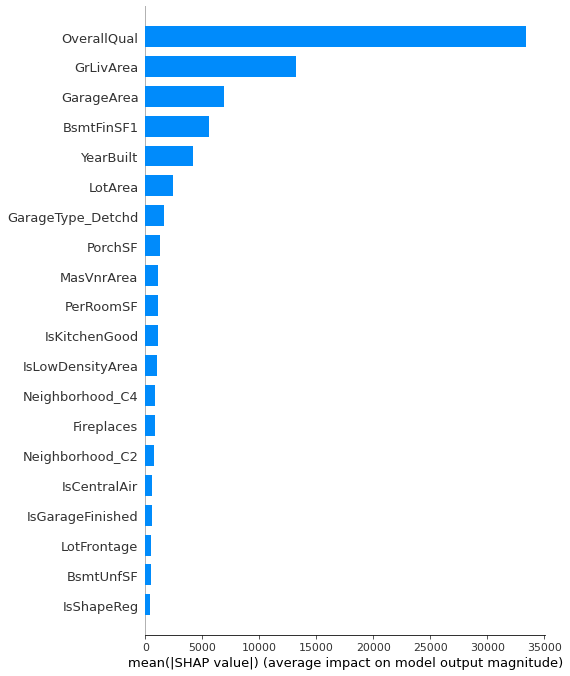

In [432]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

- almost the same as previous one

### On centroids

In [433]:
X = data.copy()
X = prepare_data_num(X)
X = prepare_data_cat(X)
X = make_cat_dummy(X)
X = drop_columns_selected(X)
X = filter_outliers(X)
X['LotFrontage'] = X['LotFrontage'].fillna(0)
X['MasVnrArea'] = X['MasVnrArea'].fillna(0)
X = standardize_num(X)
X = select_centoids(X)
y = X['SalePrice']
X.drop(columns=['SalePrice'], inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [434]:
forest = RandomForestRegressor(random_state=0)
forest.fit(X_train, y_train)
feature_names = X_train.columns
importances = forest.feature_importances_
forest_importances = pd.Series(importances, index=feature_names)
forest_importances.sort_values(ascending=False)

OverallQual           0.588908
GrLivArea             0.112516
GarageArea            0.094667
BsmtFinSF1            0.045171
YearBuilt             0.033199
LotArea               0.022648
PorchSF               0.013562
PerRoomSF             0.013428
MasVnrArea            0.013122
BsmtUnfSF             0.010791
GarageType_Detchd     0.007656
LotFrontage           0.007351
Neighborhood_C2       0.007158
IsLowDensityArea      0.005933
FloorRatio            0.005593
IsKitchenGood         0.004307
Fireplaces            0.004199
IsGarageFinished      0.002211
Exterior_1_C4         0.001730
FireplaceQual_Good    0.001505
IsHeatGood            0.001397
IsBsmConcrete         0.001143
BsmFinType_1_C1       0.000674
MasVnrType_Stone      0.000632
BsmFinType_1_C3       0.000499
dtype: float64

- almost the same variable selected

Permutated:

In [435]:
perm_importance = permutation_importance(forest, X_test, y_test)
sorted_idx = perm_importance.importances_mean.argsort()
feature_names = X_train.columns
pd.DataFrame(dict(
    name=feature_names[sorted_idx],
    importance=perm_importance.importances_mean[sorted_idx]
)).sort_values(by='importance', ascending=False).head(20).reset_index().drop(columns='index')

,name,importance
0,OverallQual,0.427394
1,GrLivArea,0.151755
2,BsmtFinSF1,0.047667
3,GarageArea,0.030959
4,YearBuilt,0.029995
5,LotArea,0.013627
6,GarageType_Detchd,0.008427
7,PorchSF,0.006582
8,PerRoomSF,0.005114
9,IsKitchenGood,0.004557


- pretty the same results

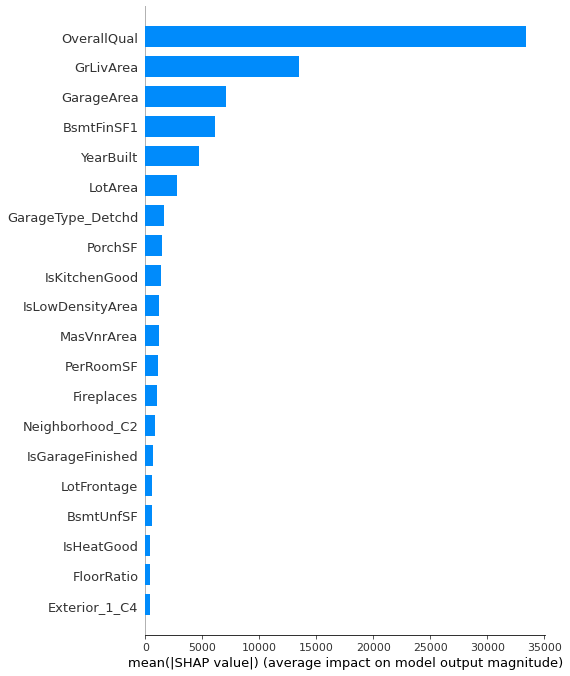

In [436]:
explainer = shap.TreeExplainer(forest)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

### Overview

Selected top-11 variables:
- OverallQual - 6
- GrLivArea - 6
- BsmtFinSF1 - 6
- GarageArea - 6
- YearBuilt	- 6
- LotArea - 6
- GarageType_Detchd - 6
- PorchSF - 6
- PerRoomSF - 6
- IsKitchenGood - 4
- IsLowDensityArea - 3
- MsvNrArea - 3
- Fireplaces - 2
- BsmtUnfSF - 2\

=> thus, keep:
OverallQual, GrLivArea, BsmtFinSF1, GarageArea,\
YearBuilt, LotArea, GarageType_Detchd, PorchSF,\
PerRoomSF, IsKitchenGood, IsLowDensityArea\

# Model selection

In [489]:
def prep_data_full(data, select_features='all'):
    X = data.copy()
    X = prepare_data_num(X)
    X = prepare_data_cat(X)
    X = make_cat_dummy(X)
    X = drop_columns_selected(X)
    X = filter_outliers(X)
    X['LotFrontage'] = X['LotFrontage'].fillna(0)
    X['MasVnrArea'] = X['MasVnrArea'].fillna(0)
    X = standardize_num(X)

    if select_features == 'centroids':
        X = select_centoids(X)
    elif select_features == 'feature_selection':
        f_selected_lst = [
            'SalePrice', 'OverallQual', 'GrLivArea', 'BsmtFinSF1', 'GarageArea',\
            'YearBuilt', 'LotArea', 'GarageType_Detchd', 'PorchSF',
            'PerRoomSF', 'IsKitchenGood', 'IsLowDensityArea'
        ]
        X = X.loc[:, ]
    y = X['SalePrice']
    X.drop(columns=['SalePrice'], inplace=True)
    return X, y

In [490]:
X, y = prep_data_full(data)

## Grids

In [ ]:
model_grid_ga_logistic = {
    'C': Continuous(0.1, 1000, distribution='uniform')
}

model_grid_ga_logistic_net = {
    'C': Continuous(0.1, 1000, distribution='uniform'),
    'l1_ratio': Continuous(0, 1, distribution='uniform')
}

model_grid_ga_knn = {
    'n_neighbors': Integer(3, 20),
    'leaf_size': Integer(20, 50)
}

model_grid_ga_svm = {
    'C': Continuous(0.1, 1000, distribution='uniform'),
    'gamma': Continuous(0.0001, 1, distribution='uniform'),
}

model_grid_ga_rf = {
    'max_depth': Integer(10, 80),
    'max_features': Integer(1, 7),
    'min_samples_leaf': Integer(1, 7),
    'min_samples_split': Integer(2, 10),
    'n_estimators': Integer(25, 500)#,
}

model_grid_ga_extra_trees = {
    'max_depth': Integer(10, 80),
    'max_features': Integer(1, 7),
    'min_samples_leaf': Integer(1, 7),
    'min_samples_split': Integer(2, 10),
    'n_estimators': Integer(25, 500)#,
}

model_grid_ga_adaboost = {
    "learning_rate": Continuous(0.01, 0.50, distribution='uniform'),
    "n_estimators": Integer(25, 500)
}

model_grid_ga_xgboost = {
    "subsample": Continuous(0.75, 1, distribution='uniform'),
    "colsample_bytree": Continuous(0.75, 1, distribution='uniform'),
    "max_depth": Integer(2, 16),
    "min_child_weight": Integer(2, 15),
    "learning_rate": Continuous(0.01, 0.50, distribution='uniform'),
    "n_estimators": Integer(25, 500)
}

model_grid_ga_lgbm = {
    "learning_rate": Continuous(0.01, 0.50, distribution='uniform'),
    "n_estimators": Integer(25, 500),
    "num_iterations": Integer(100, 1000),
    "lambda_l2": Integer(0, 3),
    "bagging_fraction": Continuous(0.8, 1, distribution='uniform'),
    "min_data_in_leaf": Integer(10, 40),
    "num_leaves": Integer(21, 51),
}

model_grid_ga_nnet = {
    'learning_rate_init': Continuous(0.01, 0.50, distribution='uniform'),
    'max_iter': Integer(200, 2000),
    'hidden_layer_sizes': Integer(100, 1000)
}

## Models on full data

In [495]:
?LarsCV

In [493]:
#LinearRegression - keep
model_grid_lars = dict(
    max_iter = Integer(100, 1000),
    max_n_alphas = Integer(100, 1500),
)

In [494]:
from sklearn.linear_model import (
    LinearRegression, Lars, Lasso, LassoLars, Ridge, ARDRegression,
    ElasticNet, BayesianRidge, GammaRegressor, HuberRegressor, 
)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from xgboost import XGBRFRegressor, XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor